Extract C II lines from MUSE cube
=================================

In [1]:
from pathlib import Path
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import numpy as np
from numpy.polynomial import Chebyshev as T
from scipy.ndimage import median_filter
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")

We have two versions of the cont-subtracted MUSE cubes:
* Rebinned 16x16 cubes are from the Raman project
* Full-resolution cubes are too big for Dropbox, so stored elsewhere

In [2]:
RAW_DATA_PATH = Path.home() / "Dropbox" / "dib-scatter-hii" / "data" / "orion-muse"
RAW_BIG_DATA_PATH = Path.home() / "Work" / "Muse-Hii-Data" / "M42"

# Load data from the smaller cube

In [3]:
hdu = fits.open(
    RAW_DATA_PATH / "muse-hr-data-wavsec23-rebin16x16-cont-sub.fits"
)["DATA"]

In [4]:
w = WCS(hdu)
w

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'AWAV'  
CRVAL : 83.780566  -5.396172  5.7884e-07  
CRPIX : 100.875  45.75  1.0  
CD1_1 CD1_2 CD1_3  : -0.00088888888888888  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  0.000888888888888889  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  8.5e-11  
NAXIS : 110  92  1404

In [5]:
chdu = fits.open(
    RAW_DATA_PATH / "muse-hr-data-wavsec23-rebin16x16-cont.fits"
)["DATA"]
true_cont_map = np.sum(chdu.data, axis=0)
true_cont_map /= np.median(true_cont_map)

# The C II 6462 pure recombination line

## Find the wavelength pixel that corresponds to the rest wavelength of the C II line

AtLL gives 2 components: 6461.95 and 6462.13, with $g_k A_{ki}$-weighted wavelength of 6462.05:

In [6]:
wav0_6462 = 6462.05 * u.Angstrom
k0 = int(w.spectral.world_to_pixel(wav0_6462))
k0

792

## Look at average spectrum in window around the line

Take a +/- 50 pixel window around rest wavelength pixel:

In [7]:
NWIN = 100
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = hdu.data[window_slice, ...]

Make an array of wavelengths for the entire cube, and then select the wavs of the window

In [8]:
VOMC = 20.0

In [9]:
nwavs, ny, nx = hdu.data.shape
wavs = w.spectral.array_index_to_world(np.arange(nwavs)).Angstrom
wavs *= (1.0 - VOMC / 3e5)
window_wavs = wavs[window_slice]
window_wavs

array([6418.67206   , 6419.52200333, 6420.37194667, 6421.22189   ,
       6422.07183333, 6422.92177667, 6423.77172   , 6424.62166333,
       6425.47160667, 6426.32155   , 6427.17149333, 6428.02143667,
       6428.87138   , 6429.72132333, 6430.57126667, 6431.42121   ,
       6432.27115333, 6433.12109667, 6433.97104   , 6434.82098333,
       6435.67092667, 6436.52087   , 6437.37081333, 6438.22075667,
       6439.0707    , 6439.92064333, 6440.77058667, 6441.62053   ,
       6442.47047333, 6443.32041667, 6444.17036   , 6445.02030333,
       6445.87024667, 6446.72019   , 6447.57013333, 6448.42007667,
       6449.27002   , 6450.11996333, 6450.96990667, 6451.81985   ,
       6452.66979333, 6453.51973667, 6454.36968   , 6455.21962333,
       6456.06956667, 6456.91951   , 6457.76945333, 6458.61939667,
       6459.46934   , 6460.31928333, 6461.16922667, 6462.01917   ,
       6462.86911333, 6463.71905667, 6464.569     , 6465.41894333,
       6466.26888667, 6467.11883   , 6467.96877333, 6468.81871

Look at the average profile

In [10]:
window_norm = window_cube / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

Also calculate the sky profile, since I am now convinced that most of the other lines are sky.

In [11]:
xskyslice, yskyslice = slice(0, 20), slice(55, 76)
window_sky = np.median(window_norm[:, yskyslice, xskyslice], axis=(1, 2))

Get some potential line IDs from Fang 2011

In [12]:
line_ids = {
    6425.9: "O II",
    6441.295: "[Ni II]",
    6445.81: "Ne II",
#    6451.97: "V II",
    6456.38: "Fe II",
#    6461.95: "C II",
    6462.05: "C II", # mean doublet wavelength
#    6462.13: "C II",
    6466.07: "Fe II",
#    6468.8: "C II",
#    6467.288: "[Ni II]",
#    6469.213: "[Co II]",
    6471.42: "O II",
#    6471.91: "C II",
    6478.72: "N II",
#    6485.2983: "[Fe II]",
#    6483.97: "O II",
#    6485.06: "O II",
#    6491.91: "O II",
    6481.706: " ",
    6482.699: " ",
    6483.753: "N I",
    6484.808: " ",
#    6491.222: "N I",
#    6499.518: " ",
    6501.41: "O II",
#    6506.302: "N I",
#    6507.024: "",
#    6521.110: "N I",
}

In [13]:
def wav2k(wav):
    return w.spectral.world_to_array_index(
         np.asarray(wav) * u.Angstrom
    )

def k2wav(k):
    if len(k):
        return w.spectral.array_index_to_world(
            np.atleast_1d(k)
        ).Angstrom
    else:
        return np.array([])

In [14]:
wav2k(list(line_ids.keys()))

array([750, 768, 773, 786, 793, 797, 804, 812, 816, 817, 818, 819, 839])

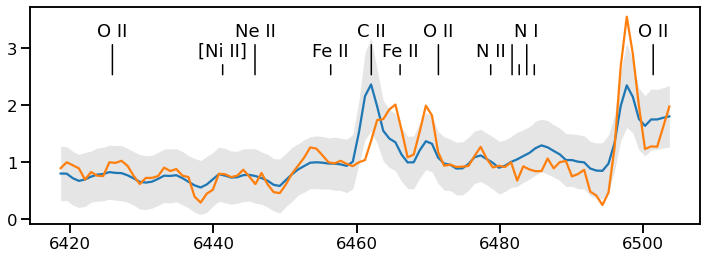

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, window_sky)
toggle = 1.0
for wav, label in line_ids.items():
    ax.annotate(
        label, 
        (wav, 2.5), 
        xytext=(0, 30 + 10 * toggle), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )
    toggle *= -1

## Deal with the sky

Now try subtracting the average sky spectrum:

In [16]:
sky = np.median(
    window_cube[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
window_norm = (window_cube - sky) / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

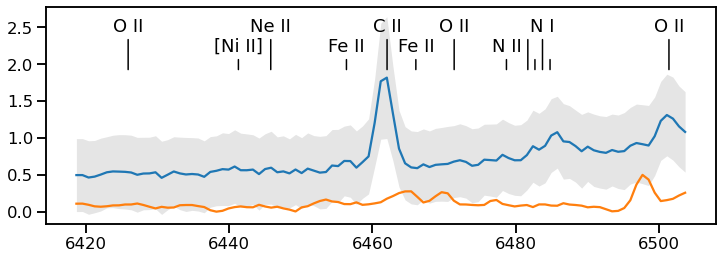

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, 0.5 * sky[:, 0, 0] / np.max(sky))
toggle = 1.0
for wav, label in line_ids.items():
    ax.annotate(
        label, 
        (wav, 1.9), 
        xytext=(0, 30 + 10 * toggle), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )
    toggle *= -1

Yes, that looks a lot better!  So most of the line IDs are not detected at all. It looks very clean around the C II line, with the possible exception of Fe II.  Then, to the red we have a possible detection of the N I multiplet at 6485 and O II at 6502

Now plot against array index 

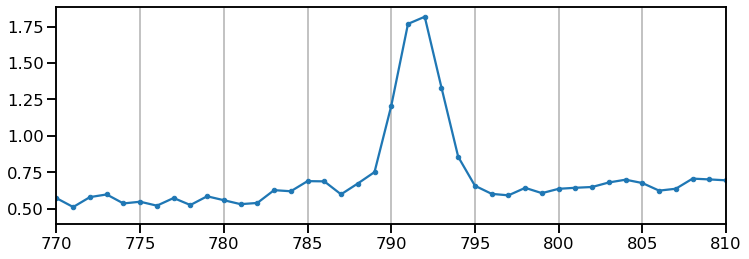

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wav2k(window_wavs), window_median, marker=".")
ax.set(
    xlim=[770, 810],
)
ax.grid(axis="x")

## Make the maps of 6462 and adjacent continuum

770-787 blue continuum. 

796-810 red continuum 

788-795 covers the line

Try it out:

In [19]:
myav = np.mean
fullsky = myav(
    hdu.data[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
fullcube_nosky = hdu.data - fullsky
cont_map_blue = myav(fullcube_nosky[770:788, ...], axis=0)
cont_map_red = myav(fullcube_nosky[796:810, ...], axis=0)
cont_map = myav(
    np.stack([cont_map_red, cont_map_blue]),
    axis=0,
)
cii_map = (fullcube_nosky[788:796, ...] - cont_map).sum(axis=0)
cii_xmap = (fullcube_nosky[790:794, ...] - cont_map).sum(axis=0)

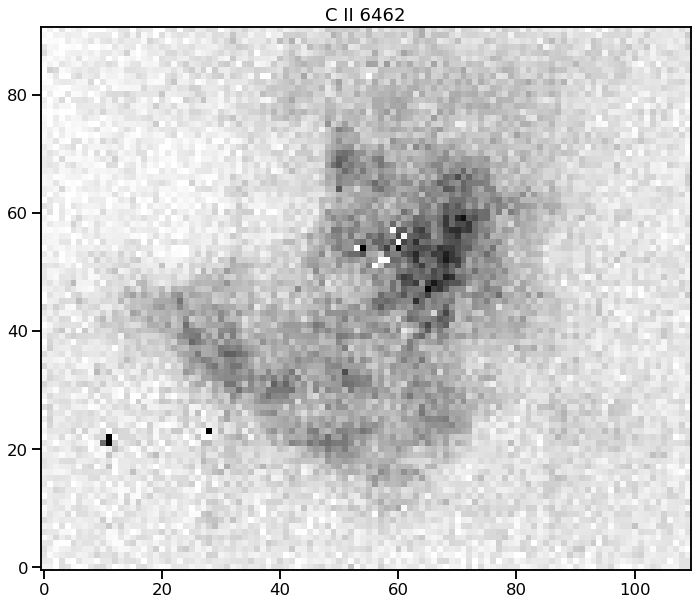

In [20]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cii_xmap, vmin=-3e4, vmax=5e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6462");

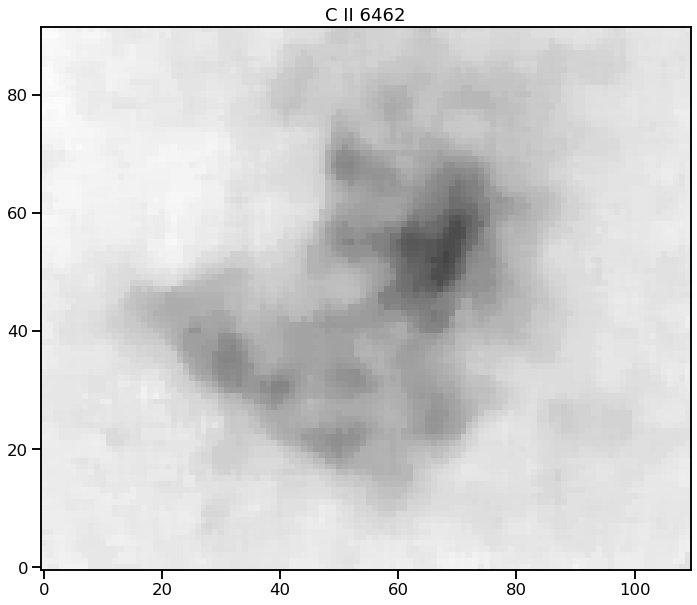

In [21]:
fig, ax = plt.subplots(figsize=(12,10))
smooth = 5
ax.imshow(
    median_filter(cii_xmap, size=smooth), 
    vmin=-3e4, vmax=5e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6462");

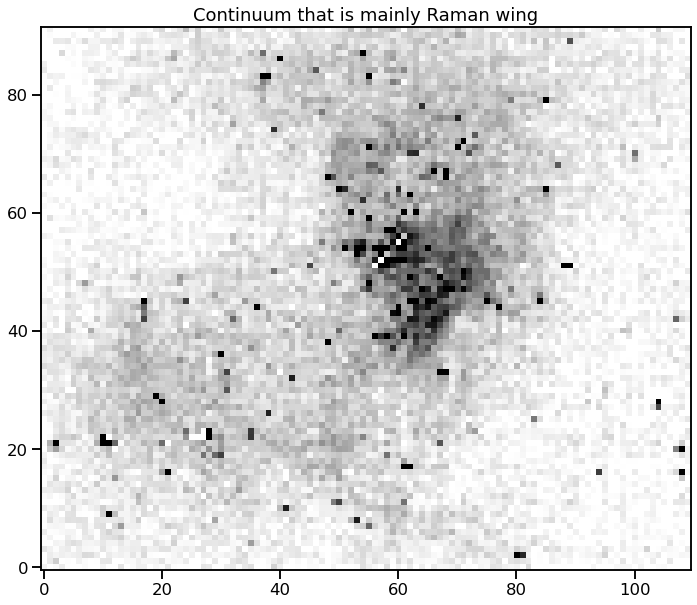

In [22]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cont_map, vmin=-2e3, vmax=1e5, origin="lower", cmap="gray_r")
ax.set_title("Continuum that is mainly Raman wing");

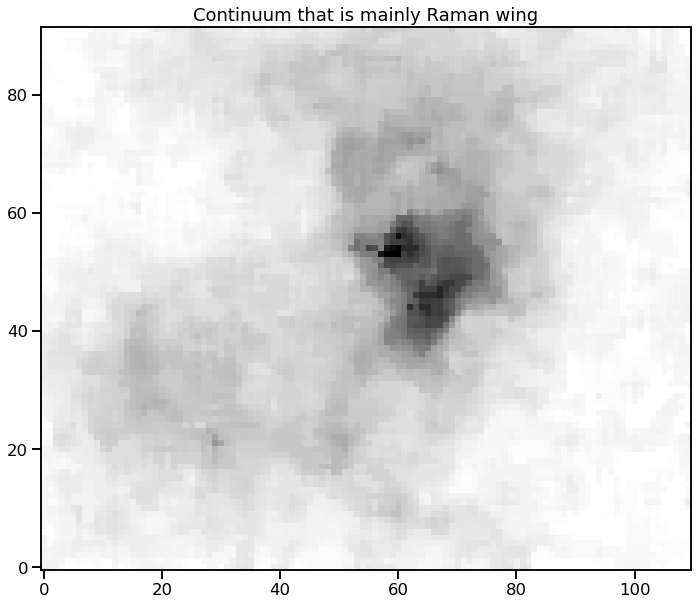

In [23]:
fig, ax = plt.subplots(figsize=(12,10))
smooth = 4
ax.imshow(
    median_filter(cont_map, size=smooth), 
    vmin=-2e3, vmax=1e5, origin="lower", cmap="gray_r")
ax.set_title("Continuum that is mainly Raman wing");

# Look at the true continuum and make a star mask

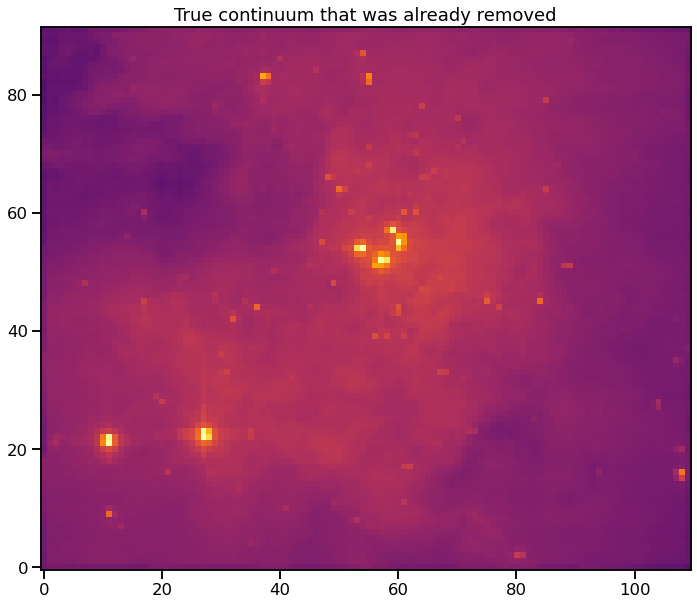

In [24]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(
    np.log10(true_cont_map), 
    vmin=-2.0, vmax=3.0, 
    origin="lower", 
    cmap="inferno"
)
ax.set_title("True continuum that was already removed");

This shows the stars and the nebular continuum. We can make a mask that will select the stars, which we might want to use later:

In [25]:
starmask = true_cont_map > 300.0

# Extract H alpha line for comparison with C II

In [26]:
wav0_6563 = 6562.79 * u.Angstrom
k0 = int(w.spectral.world_to_pixel(wav0_6563))
k0

911

In [27]:
NWIN = 100
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = hdu.data[window_slice, ...]
window_wavs = wavs[window_slice]
window_wavs

array([6519.81531667, 6520.66526   , 6521.51520333, 6522.36514667,
       6523.21509   , 6524.06503333, 6524.91497667, 6525.76492   ,
       6526.61486333, 6527.46480667, 6528.31475   , 6529.16469333,
       6530.01463667, 6530.86458   , 6531.71452333, 6532.56446667,
       6533.41441   , 6534.26435333, 6535.11429667, 6535.96424   ,
       6536.81418333, 6537.66412667, 6538.51407   , 6539.36401333,
       6540.21395667, 6541.0639    , 6541.91384333, 6542.76378667,
       6543.61373   , 6544.46367333, 6545.31361667, 6546.16356   ,
       6547.01350333, 6547.86344667, 6548.71339   , 6549.56333333,
       6550.41327667, 6551.26322   , 6552.11316333, 6552.96310667,
       6553.81305   , 6554.66299333, 6555.51293667, 6556.36288   ,
       6557.21282333, 6558.06276667, 6558.91271   , 6559.76265333,
       6560.61259667, 6561.46254   , 6562.31248333, 6563.16242667,
       6564.01237   , 6564.86231333, 6565.71225667, 6566.5622    ,
       6567.41214333, 6568.26208667, 6569.11203   , 6569.96197

In [28]:
sky = np.median(
    window_cube[:, yskyslice, xskyslice], 
    axis=(1, 2),
    keepdims=True,
)
window_norm = (window_cube - sky) / np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))
window_mad = np.median(
    np.abs(window_norm - window_median[:, None, None]), 
    axis=(1, 2)
)

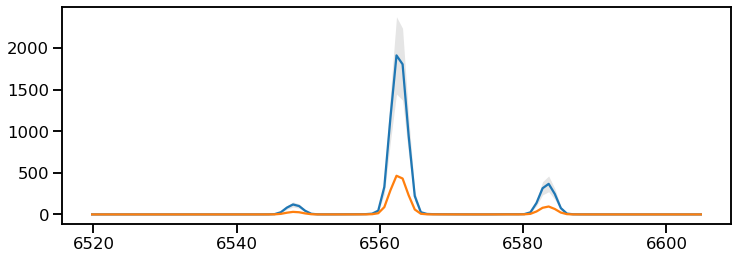

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_median)
ax.fill_between(
    window_wavs, 
    window_median - window_mad,
    window_median + window_mad,
    color="k",
    alpha=0.1,
    linewidth=0,
    zorder=-1,
)
ax.plot(window_wavs, window_mad)

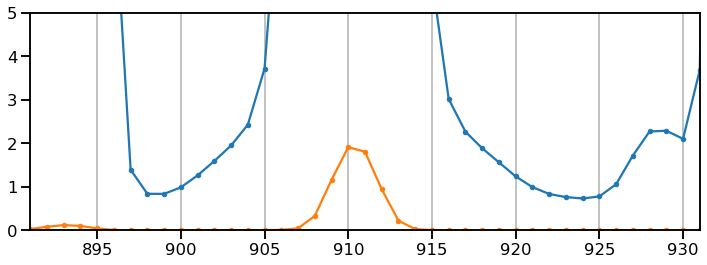

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wav2k(window_wavs), window_median, marker=".")
ax.plot(wav2k(window_wavs), window_median / 1000, marker=".")
ax.set(
    xlim=[k0 - 20, k0 + 20],
    ylim=[0, 5],
)
ax.grid(axis="x")

In [31]:
cont_map_blue = myav(fullcube_nosky[898:901, ...], axis=0)
cont_map_red = myav(fullcube_nosky[922:925, ...], axis=0)
cont_map_ha = myav(
    np.stack([cont_map_red, cont_map_blue]),
    axis=0,
)
ha_map = (fullcube_nosky[907:915, ...] - cont_map_ha).sum(axis=0)
ha_xmap = (fullcube_nosky[909:913, ...] - cont_map_ha).sum(axis=0)

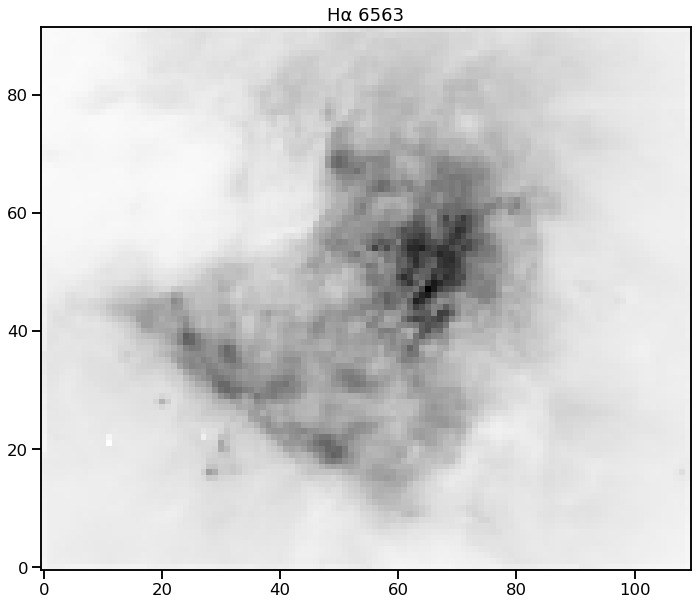

In [32]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(ha_map, origin="lower", cmap="gray_r")
ax.set_title("Hα 6563");

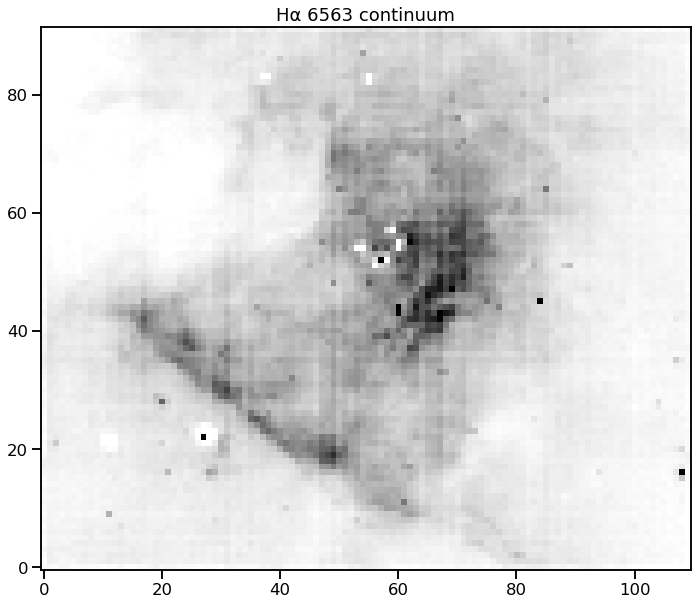

In [33]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cont_map_ha, vmin=0, vmax=1e6, origin="lower", cmap="gray_r")
ax.set_title("Hα 6563 continuum");

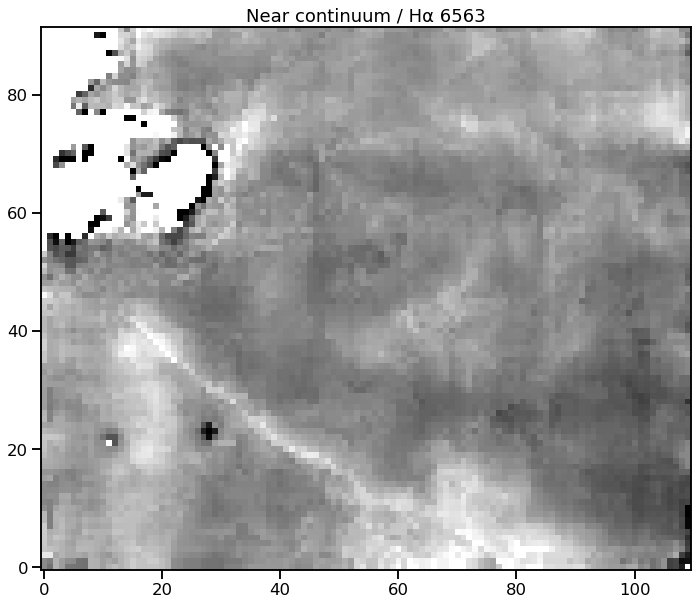

In [34]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.01 * np.median(ha_map)
smooth = 4
ratio = (
    median_filter(cont_map_ha, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio[mask] = np.nan
ax.imshow(
    ratio, 
    vmin=0, 
    vmax=2.5e-4, 
    origin="lower", 
    cmap="gray",
)
ax.set_title("Near continuum / Hα 6563");

## Ratio of 6462 to Ha

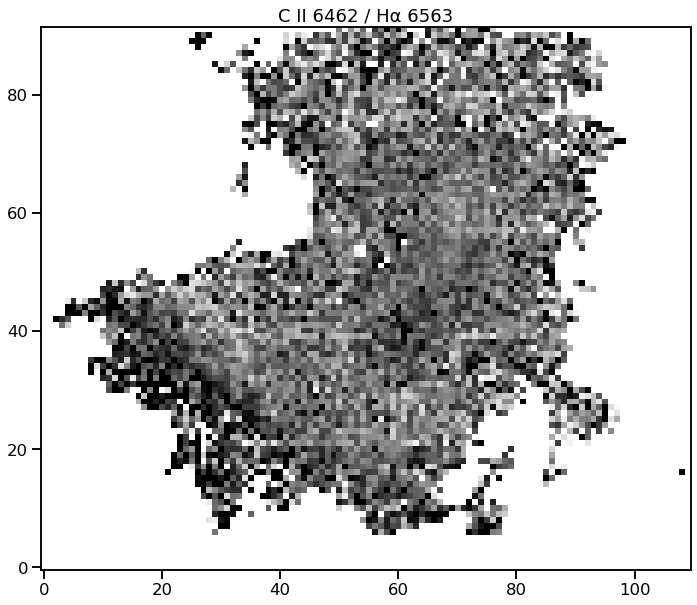

In [35]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 1 * np.median(ha_map)
ratio = cii_map / ha_map
ratio[mask] = np.nan
ax.imshow(
    ratio, 
    vmin=3.2e-5, 
    vmax=1.6e-4, 
    origin="lower", 
    cmap="gray",
)
ax.set_title("C II 6462 / Hα 6563");

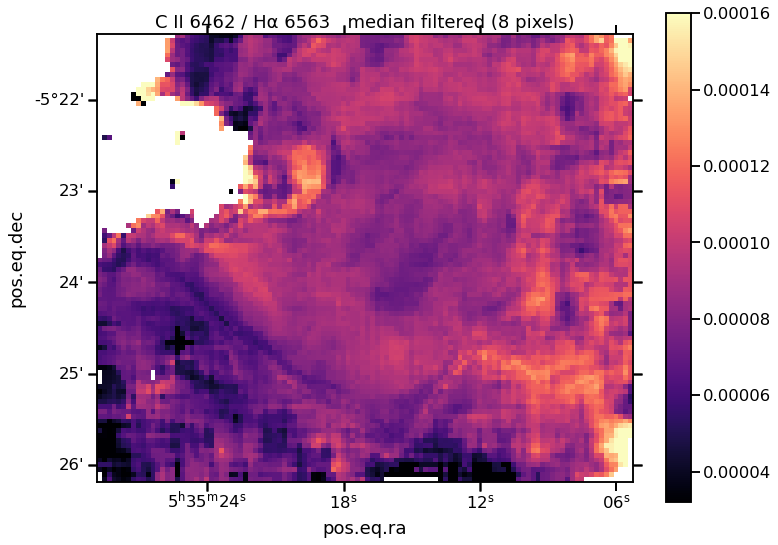

In [36]:
fig, ax = plt.subplots(
    figsize=(12,9),
    subplot_kw=dict(projection=w.celestial),
)
mask = ha_map < 0.2 * np.median(ha_map)
smooth = 8
ratio = (
    median_filter(cii_map, size=smooth) 
    / median_filter(ha_map, size=smooth)
)
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=3.2e-5, 
    vmax=1.6e-4, 
    origin="lower", 
    cmap="magma",
)
fig.colorbar(im, ax=ax)
ax.set_title(f"C II 6462 / Hα 6563   median filtered ({smooth} pixels)");

So the typical value is 1e-4.  We can estimate the C++/H+ abundance by looking at the effective recombination rates.

# C II 6151 6f–4d: a weaker recombination line

In [37]:
wav0_6151 = 6151.43 * u.Angstrom
k0_6151 = int(w.spectral.world_to_pixel(wav0_6151))
k0_6151

427

In [38]:
NWIN = 300
window_slice = slice(k0_6151 - (NWIN//2), k0_6151 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

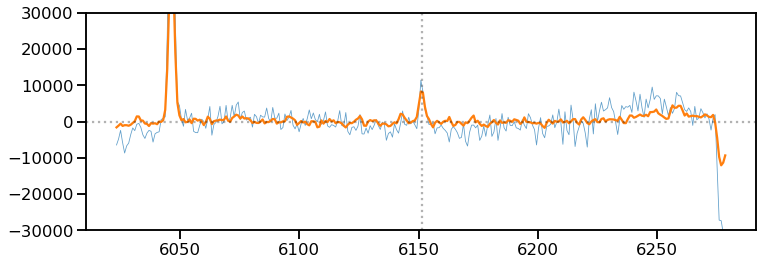

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(window_wavs, window_median)
ax.axvline(wav0_6151.value, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.set(
    ylim=[-30000, 30000],
);
#ax.plot(window_wavs, window_mean)

Looks good! Now zoom in.

In [41]:
NWIN = 100
kfull = np.arange(nwavs)
window_slice = slice(k0_6151 - (NWIN//2), k0_6151 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
kwavs = kfull[window_slice]
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

[(-3000.0, 12000.0)]

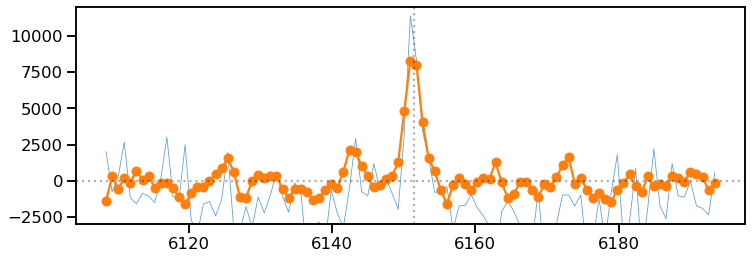

In [42]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(window_wavs, window_median, marker="o")

ax.axvline(wav0_6151.value, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.set(
    ylim=[-3000, 12000],
)

Looks like there is no need for any further continuum subtraction. Use the usual 4-pixel narrow window:

In [43]:
NWIN = 30
window_slice = slice(k0_6151 - (NWIN//2), k0_6151 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
kwavs = kfull[window_slice]
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

[(-3000.0, 12000.0)]

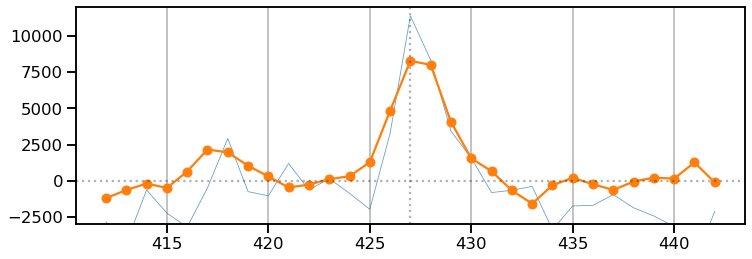

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(kwavs, window_median, marker="o")
ax.axvline(k0_6151, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.grid(axis="x")
ax.set(
    ylim=[-3000, 12000],
)

So, 426 to 429 for the line.

In [45]:
cii6151_xmap = (fullcube_nosky[426:430, ...]).sum(axis=0)

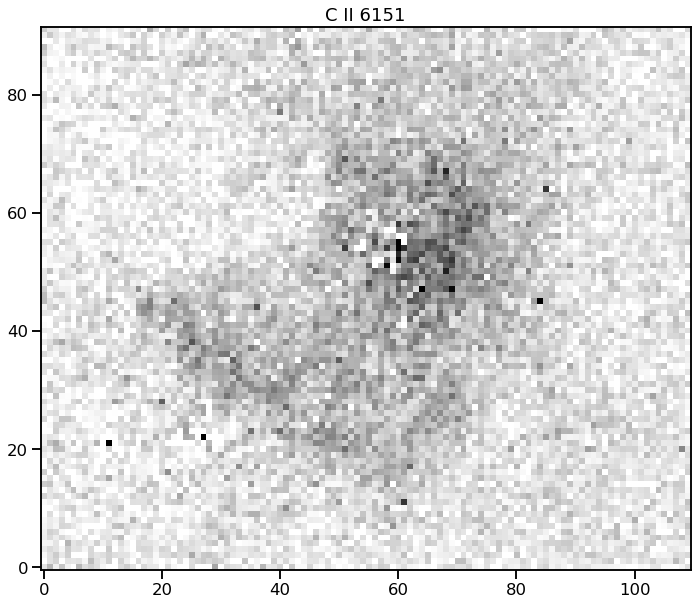

In [46]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cii6151_xmap, vmin=-2e4, vmax=3e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6151");

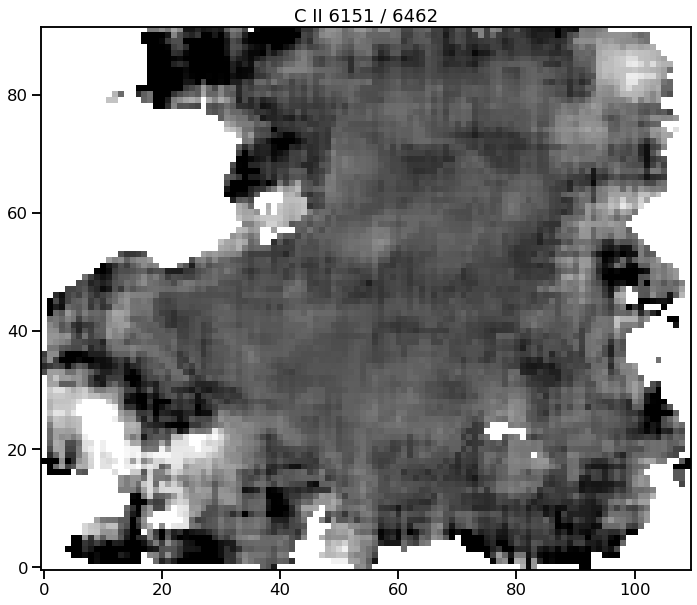

In [47]:
fig, ax = plt.subplots(figsize=(12,10))
smooth = 8
ratio = median_filter(cii6151_xmap, smooth) / median_filter(cii_xmap, smooth)
mask = ha_map < 0.5 * np.median(ha_map)
ratio[mask] = np.nan
ax.imshow(ratio, vmin=-0.05, vmax=0.7, origin="lower", cmap="gray_r")
ax.set_title("C II 6151 / 6462");

# Now try and extract C II 6578

Make use of the sky-subtracted cube that we already have.  Extract a wide-ish window centered on the Ha line since we want to have a food sampling of the two [N II] lines and of the Ha wings:

In [48]:
NWIN = 160
window_slice = slice(k0 - (NWIN//2), k0 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
window_norm = window_cube/ np.median(window_cube, axis=0)
window_median = np.median(window_norm, axis=(1, 2))

Find the shift in wav pixels between the two [N II] lines.

In [49]:
wav0_6548 = 6548.05 * u.Angstrom
wav0_6583 = 6583.45 * u.Angstrom
k0_6548 = w.spectral.world_to_pixel(wav0_6548)
k0_6583 = w.spectral.world_to_pixel(wav0_6583)
k0_6548, k0_6583

(array(893.70588235), array(935.35294118))

In [50]:
kshift = k0_6583 - k0_6548
kshift

41.64705882352928

Range of wav pixels for the window centered on Ha, and also for the full cube:

In [51]:
kwindow = wav2k(window_wavs)
kfull = np.arange(nwavs)

## Fit and remove the Raman wings

We fit two polynomials to the Ha wings: 
* `p` is fitted to the blue wing and is subtracted from the 6548 profile before shifting it. 
* `p2` is fitted to the red wing and is directly subtracted from the C II profile. 

In [52]:
p1 = T.fit(kwindow[:45], window_median[:45], deg=2)
p2 = T.fit(kwindow[-40:], window_median[-40:], deg=2)

We will use the same shape of polynomial for all pixels, so we don't have to do lots of fitting, which would be slow.

We calculate the median of the ratio of the true wing to the polynomial, which we will use for scaling it. This is about 96% in the blue wing because it cuts out all the faint lines, which had pulled up the fit a bit. 

In [53]:
fac1 = np.median(window_median[:45] / p1(kwindow[:45]))
fac2 = np.median(window_median[-40:] / p2(kwindow[-40:]))
fac1, fac2

(0.9538885081159763, 0.9914327531545049)

## Shift/interpolate/scale the 6548 line to subtract from 6583

Make a version of the wing-subtracted 6548 profile that is shifted and interpolated to account for the wavelength difference between 6548 and 6583. We multiply by 3 to account for the A ratio and only subtract scale factor times the polynomial.

In [54]:
nii_A_ratio = 2.95765481
window_shift = np.interp(
    kwindow, 
    kwindow + kshift,
    nii_A_ratio * (window_median - fac1 * p1(kwindow)),
)

## Slight smoothing of original profile to match diffusive interpolation

The linear interpolation causes a small amount of smoothing.  Therefore, we must also apply smoothing to the original profile, otherwise we will get ringing artefacts when we do the subtraction.  I use a 3-pixel peaked kernel that sums to 1, where `delta` is the relative height of the "wing" pixels, which I determine by trial and error. 

In [55]:
from scipy.ndimage import convolve
delta = 0.095
kernel = np.array([delta, 1.0 - 2 * delta, delta])
window_median_smooth = convolve(window_median, kernel)

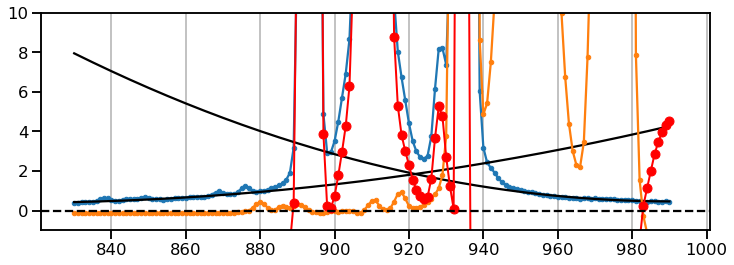

In [56]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwindow, window_median, marker=".")
ax.plot(kwindow, fac1 * p1(kwindow), color="k")
ax.plot(kwindow, fac2 * p2(kwindow), color="k")
ax.plot(kwindow, window_shift, marker=".")
ax.plot(
    kwindow, 
    window_median_smooth - window_shift - fac2 * p2(kwindow), 
    marker="o", color="r", lw=2)

ax.axhline(0.0, color="k", linestyle="dashed")
ax.set(
    xlim=[k0 - 90, k0 + 90],
    ylim=[-1, 10],
)
ax.grid(axis="x")

Here I plot the following: 
* original profile in blue
* fitted and scaled wings in black
* shifted and scaled interpolated 6548 profile in orange
* smoothed blue minus orange in red – this should give the isolated C II profile

In [57]:
wav0_6578 = 6578.05 * u.Angstrom
k0_6578 = w.spectral.world_to_pixel(wav0_6578)
k0_6578

array(929.)

Zoom in on the 6578 line:

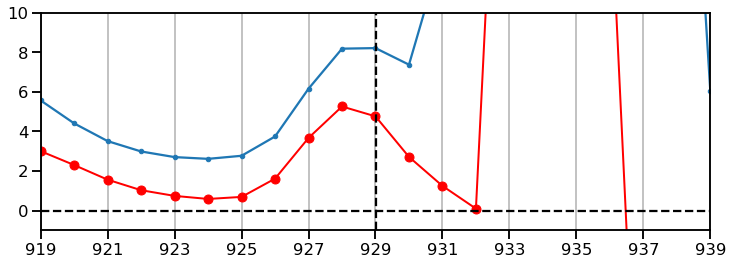

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwindow, window_median, marker=".")
ax.plot(
    kwindow, 
    window_median_smooth - window_shift - fac2 * p2(kwindow), 
    marker="o", color="r", lw=2)

ax.axhline(0.0, color="k", linestyle="dashed")
ax.axvline(k0_6578, color="k", linestyle="dashed")
ax.set(
    xlim=[k0_6578 - 10, k0_6578 + 10],
    ylim=[-1, 10],
    xticks=range(int(k0_6578) - 10, int(k0_6578) + 11, 2),
)
ax.grid(axis="x")

So it looks like pixels 925–932 span the entire line. However, at 931 the C II contribution is only 10% of the total, so there will be lots of noise.  And at 932 the C II contribution is essentially zero and the [N II] contamination is enormous. 

## Now apply the same procedure pixel-by-pixel to make map of 6578

First, do the wings:

In [59]:
fac1 = np.median(
    window_cube[:45, ...] / p1(kwindow[:45])[:, None, None],
    axis=0,
)
fac2 = np.median(
    window_cube[-40:, ...] / p2(kwindow[-40:])[:, None, None],
    axis=0,
)

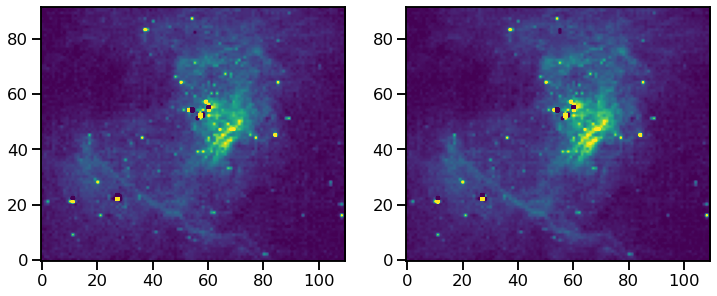

In [61]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(fac1, vmin=-1e4, vmax=4e5, origin="lower")
ax2.imshow(fac2, vmin=-1e4, vmax=4e5, origin="lower")

**Wow, these are good images of the Raman wings!** *They look much better than the ones in my paper!*

Now do the shift of the wing-subtracted 6548 line. We have to use the scipy function because the numpy one does not support interpolation along one axis of a multidimensional array. We still  do a linear interpolation though because the data are too noisy to support anything fancy like spline. 

In [62]:
from scipy.interpolate import interp1d

interpolator = interp1d(
    kwindow + kshift,
    nii_A_ratio * (
        window_cube 
        - fac1[None, :, :] * p1(kwindow)[:, None, None]
    ),
    axis=0,
    kind="linear",
    fill_value="extrapolate",
)
window_shift = interpolator(kwindow)

Do the smoothing of the original cube. We need to reshape the kernel to make it 3-dimensional. 

In [63]:
window_cube_smooth = convolve(window_cube, kernel.reshape((3, 1, 1)))

Find pixel offset of window from start of wav axis

In [64]:
kw0 = kwindow[0]
kw0

830

Subtract the shifted 6548 line and the red wing from the smoothed cube. Then sum up the wav pixels that bracket the C II line:

In [65]:
window_cube_extract = (
    window_cube_smooth 
    - window_shift
    - fac2[None, :, :] * p2(kwindow)[:, None, None]
)
cii6578_map = np.sum(
    window_cube_extract[925 - kw0:933 - kw0, ...],
    axis=0,
)
cii6578_xmap = np.sum(
    window_cube_extract[927 - kw0:931 - kw0, ...],
    axis=0,
)

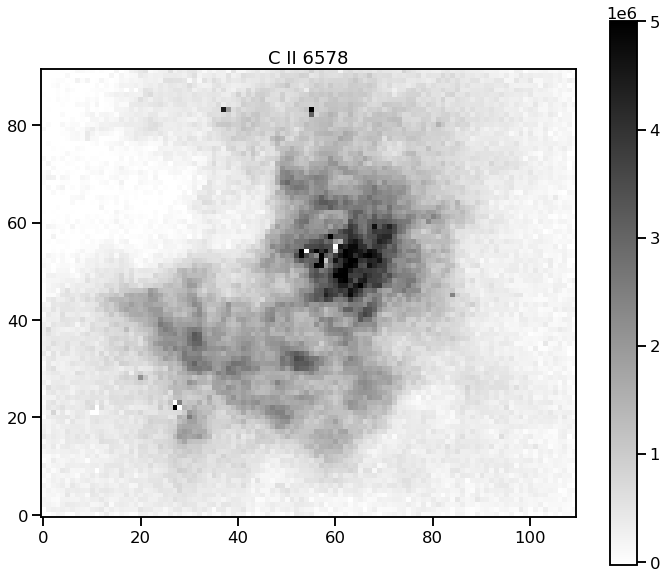

In [66]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(cii6578_xmap, vmin=-3e4, vmax=5e6, origin="lower", cmap="gray_r")
fig.colorbar(im, ax=ax)
ax.set_title("C II 6578");

## Ratio of 6462 / 6578

This is similar to the 4267 / 6578 ratio that Eduardo was estimating.  There should be a particular value predicted for recombination.

Davey et al (2000) have 4267 / 6462 = (27.6/4267) / (4.29/6462) = 9.74 at 1e4 K. 

The mean value we find below of 6462 / 6578 = 0.12 would correspond to 4267 / 6578 = 9.74 * 0.12 = 1.17, which is smaller than Eduardo was finding. 

He got 4267 / 6578 = 2 for the highest ionization regions, which corresponds to 6462 / 6578 = 2 / 9.74 = 0.21

This is close to the biggest values of 6462 / 6578 that I find 

Davey et al (2000) have 6462 / 6578+6583 = 0.13 but we need to correct for the unobserved 6583 component. Assuming ratio of statistical weights, we multiply by (1 + 2) / 3 = 1.5 to get 0.195. So we will use that. 



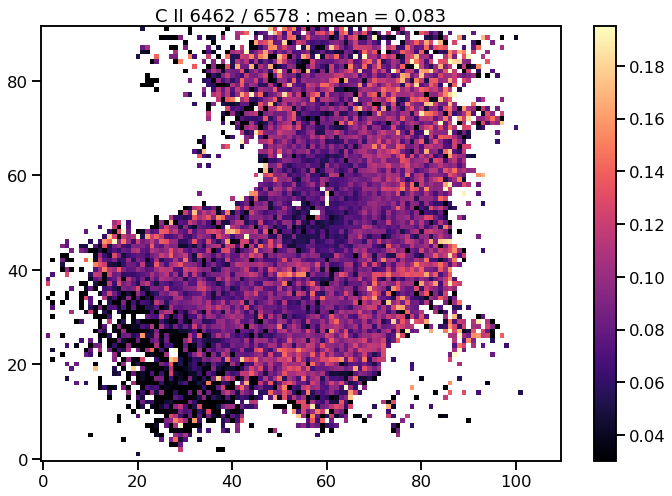

In [67]:
fig, ax = plt.subplots(figsize=(12,8))
smooth = 1
mapA, mapB = cii_xmap, cii6578_xmap
#mapA, mapB = cii_map, cii6578_map
mask = median_filter(mapB, smooth) < 1.0 * np.median(mapB)
mask = mask | starmask
ratio = median_filter(mapA, smooth) / median_filter(mapB, smooth)
av_ratio = np.sum(mapA[~mask]) / np.sum(mapB[~mask])
ratio[mask] = np.nan
im = ax.imshow(ratio, vmin=0.03, vmax=0.195, origin="lower", cmap="magma")
fig.colorbar(im, ax=ax)
ax.set_title(
    f"C II 6462 / 6578 : mean = {av_ratio:.3f}"
);

So that looks really good, even without any smoothing.  The highest values a bit less than the predicted pure-recomb value of 0.195. 

x = (0.195 / 0.083) - 1 = 135% is the average fluorescence fraction, which has peaks of (0.195 / 0.04) - 1 = 400% around th2A



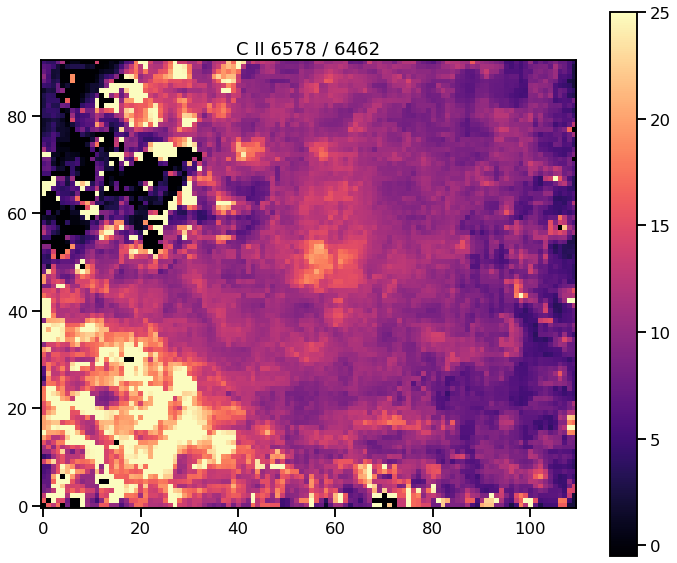

In [68]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.6 * np.median(ha_map)
smooth = 4
ratio = (
    median_filter(cii6578_xmap, size=smooth) 
    / median_filter(cii_xmap, size=smooth)
)
im = ax.imshow(ratio, vmin=-0.5, vmax=25, origin="lower", cmap="magma")
fig.colorbar(im, ax=ax)
ax.set_title("C II 6578 / 6462");

## Subtract recombination contribution to get pure fluorescent 6578 emission

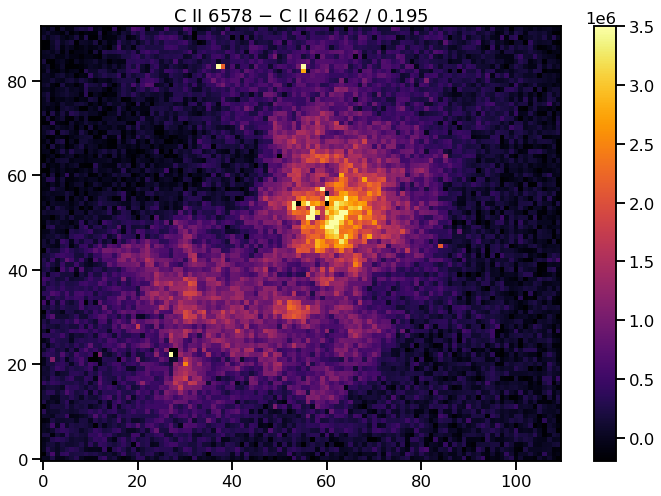

In [69]:
fig, ax = plt.subplots(figsize=(12,8))
FACTOR = 0.195
excess = cii6578_xmap - cii_xmap / FACTOR
im = ax.imshow(
    median_filter(excess, size=1), 
    vmin=-2e5, vmax=3.5e6, 
    origin="lower", 
    cmap="inferno",
)
fig.colorbar(im, ax=ax)
ax.set_title(fr"C II 6578 $-$ C II 6462 / {FACTOR}");

Ratio of fluorescent excess to H alpha.

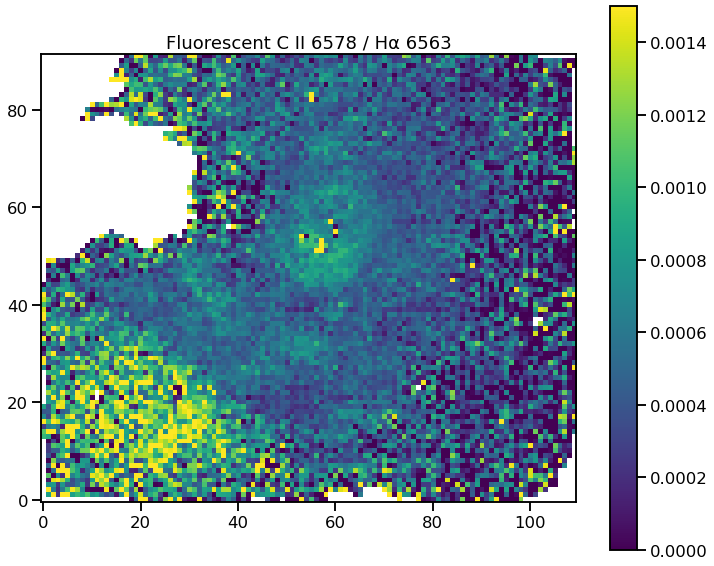

In [70]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.3 * np.median(ha_map)
ratio = excess / ha_xmap
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=0, 
    vmax=0.0015, 
    origin="lower", 
    cmap="viridis",
)
fig.colorbar(im, ax=ax)
ax.set_title("Fluorescent C II 6578 / Hα 6563");

This really empasises the th2A region because the H alpha is weak there. 

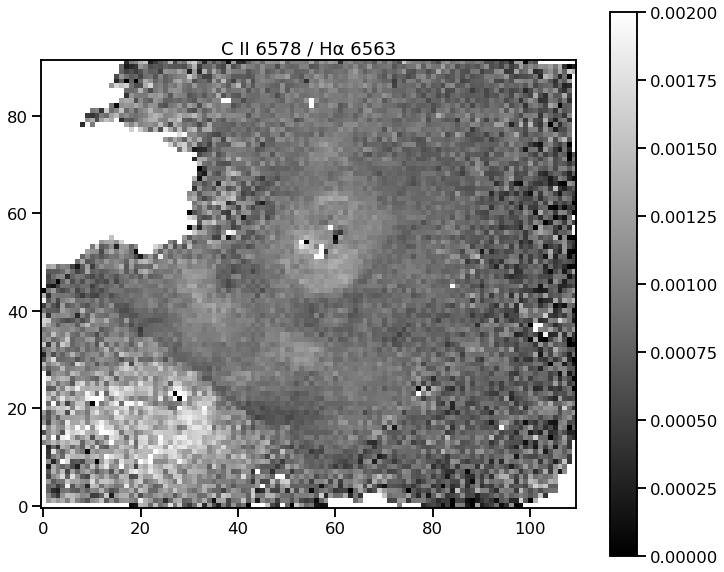

In [71]:
fig, ax = plt.subplots(figsize=(12,10))
mask = ha_map < 0.3 * np.median(ha_map)
ratio = cii6578_xmap / ha_xmap
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=0, 
    vmax=0.002, 
    origin="lower", 
    cmap="gray",
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 6578 / Hα 6563");

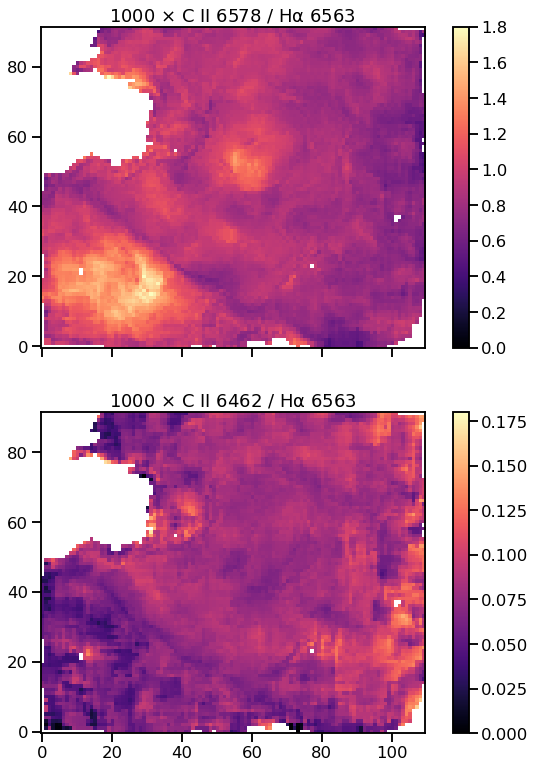

In [72]:
fig, [ax1, ax2] = plt.subplots(
    2, 1, 
    figsize=(10, 13),
    sharex=True,
)

mask = ha_map < 0.3 * np.median(ha_map)

SCALE = 1000
cmap = "magma"
smooth = 6

ratio1 = (
    median_filter(cii6578_xmap, size=smooth) 
    / median_filter(ha_xmap, size=smooth)
)
ratio1[mask] = np.nan
im1 = ax1.imshow(
    SCALE * ratio1, 
    vmin=0, 
    vmax=SCALE * 0.0018, 
    origin="lower", 
    cmap=cmap,
)
fig.colorbar(im1, ax=ax1)
ax1.set_title(fr"{SCALE} $\times$ C II 6578 / Hα 6563")

ratio2 = (
    median_filter(cii_xmap, size=smooth) 
    / median_filter(ha_xmap, size=smooth)
)
ratio2[mask] = np.nan
im2 = ax2.imshow(
    SCALE * ratio2, 
    vmin=0, 
    vmax=SCALE * 0.00018, 
    origin="lower", 
    cmap=cmap,
)
fig.colorbar(im2, ax=ax2)
ax2.set_title(fr"{SCALE} $\times$ C II 6462 / Hα 6563")
...;

# Look at the excited-core lines: 6780 and 6787

Transition is 2s 2p ($^3$P$_o$) 3s $^4$P$_o$– 2s 2p ($^3$P$_o$) 3p $^4$D.  Note that the quartet state (S = 3/2) is taking into account all 3 electrons.

```
Atomic Line List version: 3.00b4   Constructed: 2021-07-21 14:47 GMT
Wavelength range: 0 - inf   Unit: Angstrom   Type: Air
Radial velocity: 0 km/s
Element/Spectrum: C  II

-LAB-WAVL-ANG-AIR-|-DLAM--|-SPC-|TT|--------CONFIGURATION--------|-TERM--|-J_i-J_k-|--A_ki---|-TPF-|-LEVEL-ENERGY--CM^-1-|-REF---|
   6779.94         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  3/2 - 5/2 2.500e+07    24 166990.73 - 181736.05 ASD
   6780.59         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  1/2 - 3/2 1.490e+07    24 166967.13 - 181711.03 ASD
   6783.91         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  5/2 - 7/2 3.540e+07    24 167035.71 - 181772.41 ASD
   6787.21         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  1/2 - 1/2 2.950e+07    24 166967.13 - 181696.66 ASD
   6791.47         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  3/2 - 3/2 1.870e+07    24 166990.73 - 181711.03 ASD
   6798.10         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  3/2 - 1/2 5.800e+06    24 166990.73 - 181696.66 ASD
   6800.69         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  5/2 - 5/2 1.040e+07    24 167035.71 - 181736.05 ASD
   6812.28         4.1e-02  C II E1 2s.2p.(3Po).3s-2s.2p.(3Po).3p 4Po-4D  5/2 - 3/2 1.710e+06    24 167035.71 - 181711.03 ASD

gk*Aki weighted average wavelength:    6785.85      
```

In [73]:
line_strengths_678X = {
    6779.94: 2.5,
    6780.59: 1.5,
    6783.91: 3.5,
    6787.21: 3.0,
    6791.47: 1.9,
    6798.10: 0.6,
    6800.69: 1.0,
    6812.28: 0.2,
}

In [74]:
wav0_678X = 6785.85 * u.Angstrom
k0_678X = int(w.spectral.world_to_pixel(wav0_678X))
k0_678X

1173

First look at a wide spectral wnidow around the lines:

In [75]:
NWIN = 300
window_slice = slice(k0_678X - (NWIN//2), k0_678X + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
#window_norm = window_cube/ np.median(window_cube, axis=0)
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

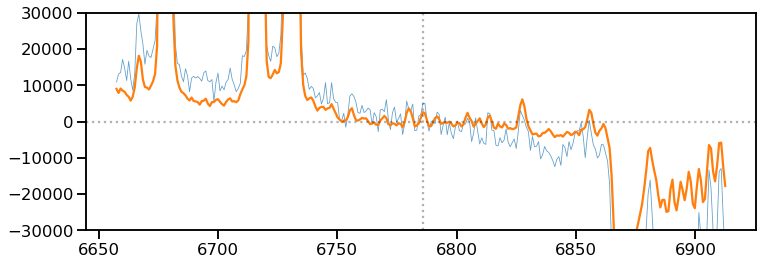

In [76]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(window_wavs, window_median)
ax.axvline(wav0_678X.value, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.set(
    ylim=[-30000, 30000],
);
#ax.plot(window_wavs, window_mean)

So there is not much clean continuum around there.  We have the [S II] lines to the blue and the terrestrial absorption to the red.  However, we seem to have a good detection of three lines.  

Also, mean (blue) is a lot noisier than median (orange).

Next, zoom in on a narrower spectral window:

In [77]:
NWIN = 100
window_slice = slice(k0_678X - (NWIN//2), k0_678X + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
kwavs = kfull[window_slice]
#window_norm = window_cube/ np.median(window_cube, axis=0)
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

[(-3000.0, 8000.0)]

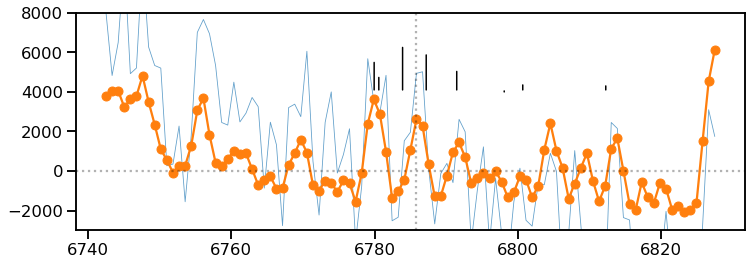

In [78]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(window_wavs, window_median, marker="o")
for wav, strength in line_strengths_678X.items():
    ax.annotate(
        " ", 
        (wav, 4000), 
        xytext=(0, 15 * strength), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )

ax.axvline(wav0_678X.value, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.set(
    ylim=[-3000, 8000],
)

The wavelengths look good for 6780 and possibly 6791.5.  But they do not line up very well for 6784 and 6787, which should be the strongest components (if in LTE). 

Now plot again, but as a function of pixel and zoomed in even more:

In [79]:
NWIN = 50
window_slice = slice(k0_678X - (NWIN//2), k0_678X + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
kwavs = kfull[window_slice]
#window_norm = window_cube/ np.median(window_cube, axis=0)
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

[(-3000.0, 8000.0)]

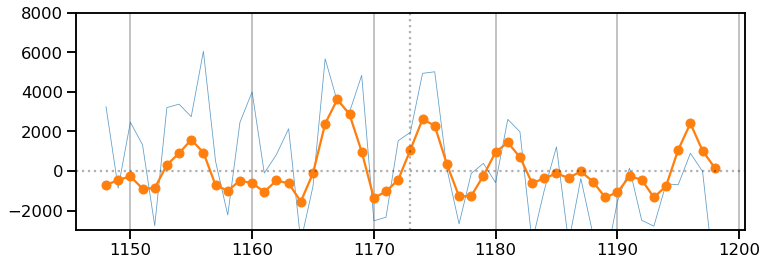

In [80]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(kwavs, window_median, marker="o")
ax.axvline(k0_678X, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.grid(axis="x")
ax.set(
    ylim=[-3000, 8000],
)

So, for continuum we can take 1158 to 1164 and 1183 to 1190

For 6780 we can take 1165 to 1170 

For 6787 we can take 1172 to 1177

For 6792 we can take 1178 to 1183 

In [81]:
cont_map_678X_blue = myav(fullcube_nosky[1158:1165, ...], axis=0)
cont_map_678X_red = myav(fullcube_nosky[1183:1191, ...], axis=0)
cont_map_678X = myav(
    np.stack([cont_map_678X_red, cont_map_678X_blue]),
    axis=0,
)
cii6780_map = (fullcube_nosky[1164:1171, ...] - cont_map_678X).sum(axis=0)
cii6787_map = (fullcube_nosky[1171:1178, ...] - cont_map_678X).sum(axis=0)
cii6792_map = (fullcube_nosky[1178:1185, ...] - cont_map_678X).sum(axis=0)

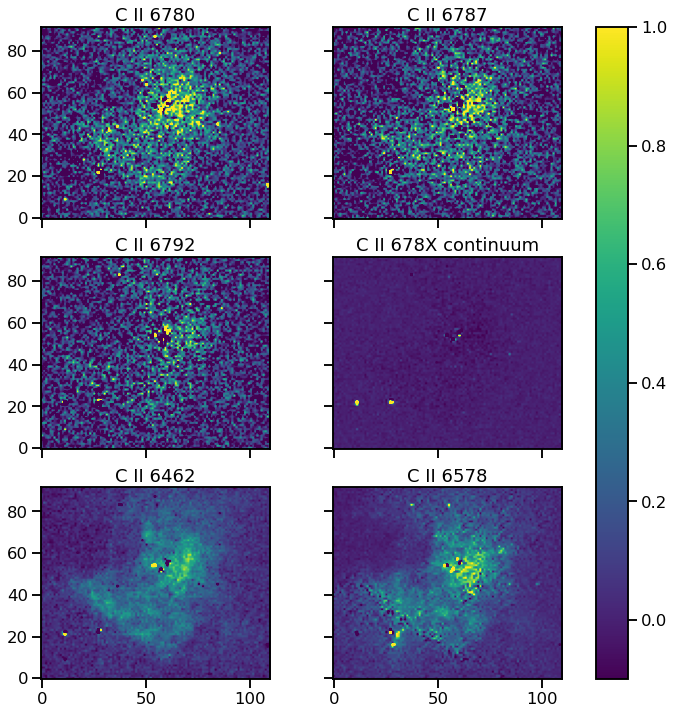

In [82]:
fig, axes = plt.subplots(
    3, 2, 
    figsize=(12, 12),
    sharex=True,
    sharey=True,
)
smooth = 1
for ax, _map, label, scale in zip(
    axes.flat,
    [cii6780_map, cii6787_map, cii6792_map, cont_map_678X, cii_map, cii6578_map],
    ["6780", "6787", "6792", "678X continuum", "6462", "6578"],
    [1.2e5] * 4 + [0.7e6, 0.7e7],
):
    im = ax.imshow(
        median_filter(_map, smooth) / scale, 
        vmin=-0.1, vmax=1.0, 
        origin="lower", cmap="viridis",
    )
    ax.set_title(f"C II {label}")
fig.colorbar(im, ax=axes)
...;

Note the top 4 panels all have the same normalization. So the fact that the continuum panel looks blank means that 

So the 6780 and 6787 components look vahely like one would expect for a C II line.  Bt the 6792 is clearly contaminated with something else. 

## Use narrower wavelength window

Also try taking a narrower window of 4 pixels to see if that improves the signal to noise. 


In [85]:
cii6780_xmap = (fullcube_nosky[1166:1170, ...] - cont_map_678X).sum(axis=0)
cii6787_xmap = (fullcube_nosky[1173:1177, ...] - cont_map_678X).sum(axis=0)
cii6792_xmap = (fullcube_nosky[1179:1183, ...] - cont_map_678X).sum(axis=0)

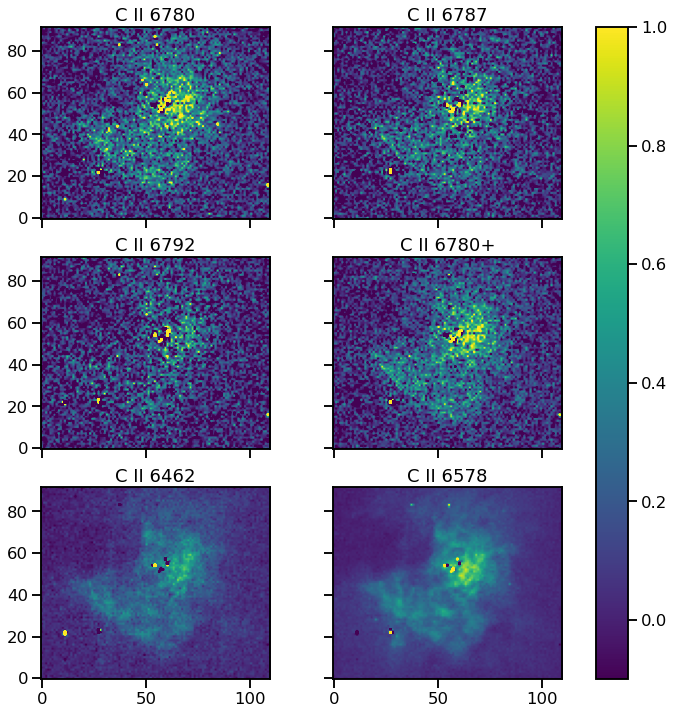

In [86]:
fig, axes = plt.subplots(
    3, 2, 
    figsize=(12, 12),
    sharex=True,
    sharey=True,
)
smooth = 1
for ax, _map, label, scale in zip(
    axes.flat,
    [
        cii6780_xmap, 
        cii6787_xmap, 
        cii6792_xmap, 
        cii6780_xmap + cii6787_xmap, # + cii6792_xmap, 
        cii_xmap, 
        cii6578_xmap
    ],
    ["6780", "6787", "6792", "6780+", "6462", "6578"],
    [1.15e5] * 3 + [2.1e5, 0.6e6, 0.6e7],
):
    im = ax.imshow(
        median_filter(_map, smooth) / scale, 
        vmin=-0.1, vmax=1.0, 
        origin="lower", cmap="viridis",
    )
    ax.set_title(f"C II {label}")
fig.colorbar(im, ax=axes)
...;

So that actually improves the s/n quite a bit.  However, it may have resulted in the loss of some flux, which we will correct in a moment. 
I have swapped the continuum panel for the sum of 6780+6787. I don't include 6792 in the sum since it clearly has a different distribution near the bar – probably blend with a low-ionization line like Fe II. 

This has now been retrofitted to all the other lines.

### How much flux is lost in the narrower wavelength windows?

In [88]:
for f in [np.median, np.sum, np.max]:
    print(f)
    for _xmap, _map, label in [
        [cii6780_xmap, cii6780_map, 6780],
        [cii6787_xmap, cii6787_map, 6787],        
        [cii_xmap, cii_map, 6462],        
        [cii6578_xmap, cii6578_map, 6578],        
        [ha_xmap, ha_map, 6563],        
    ]:
        print(f"{label}:", f(_xmap) / f(_map))

<function median at 0x7fb8d0cfcca0>
6780: 1.0645375990351242
6787: 1.0438554804307023
6462: 0.7313087886194746
6578: 0.8367917979831612
6563: 0.812122543587748
<function sum at 0x7fb8b0b2d8b0>
6780: 1.2838211250070917
6787: 1.0765883609182045
6462: 0.7440737132512326
6578: 0.8245480855179328
6563: 0.8067200744776788
<function amax at 0x7fb8c0150160>
6780: 1.496424199221929
6787: 0.6016291148654365
6462: 0.6752288278158003
6578: 0.5501806575807845
6563: 0.8222333380483061


The previous cell calculates the ratio of the narrow window (4 pixels) to the wide window (8 or 7 pixels) for each line, taking the median, sum, or max over the whole map. 

There is not much difference between the median and the sum. We will use the median.

For the 6780+ lines it is bigger than 100%, which means that the wide windows must include pixels that are on average *below* the estimated continuum.  This probably means that the continuum is not well estimated! (Maybe the continuum range includes some weak lines).  Whatever the reason, it is best to use the narrow window. 

For the other lines, it is around 80%, which seems reasonable.  Obviously, the most reliable estimate is for H alpha, which is 81%. 
It is probably best to assume that it is the same for all lines, in which case there is no need to make any correction when taking line ratios, so long as all lines use the same narrow window. 

On the other hand, if we ever want absolute fluxes, we have to remember to divide by 0.8 (multiply by 1.25). 

For 6462, the value is 74%, which is slightly less. However, the most likely explanation is that the wings are contaminated by a blend with another line.  In that case, the narrow indow is still best, and there is no need to make any correction to the ratios. 

# Look at the higher fluorescent lines $\lambda\lambda$ 6257, 6260

At first glance, they might have a higher fluorescent fraction

```
Atomic Line List version: 3.00b4   Constructed: 2021-07-21 14:47 GMT
Wavelength range: 0 - inf   Unit: Angstrom   Type: Air
Radial velocity: 0 km/s
Element/Spectrum: C  II

-LAB-WAVL-ANG-AIR-|-DLAM--|-SPC-|TT|CONFIGURATION|-TERM--|-J_i-J_k-|--A_ki---|-TPF-|-LEVEL-ENERGY--CM^-1-|-REF---|
   6257.18         3.5e-02  C II E1 2s2.4p-2s2.5d 2Po-2D  1/2 - 3/2 3.130e+06    24 162517.89 - 178495.11 ASD
   6259.56         3.5e-02  C II E1 2s2.4p-2s2.5d 2Po-2D  3/2 - 5/2 3.770e+06    24 162524.57 - 178495.71 ASD
   6259.80         3.5e-02  C II E1 2s2.4p-2s2.5d 2Po-2D  3/2 - 3/2 6.280e+05    24 162524.57 - 178495.11 ASD

gk*Aki weighted average wavelength:    6258.79        
```

In [89]:
line_strengths_6259 = {
    6257.18: 3.1,
    6259.56: 3.8,
    6259.80: 0.6,
}

In [90]:
wav0_6259 = 6258.79 * u.Angstrom
k0_6259 = int(w.spectral.world_to_pixel(wav0_6259))
k0_6259

553

In [91]:
NWIN = 300
window_slice = slice(k0_6259 - (NWIN//2), k0_6259 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
#window_norm = window_cube/ np.median(window_cube, axis=0)
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

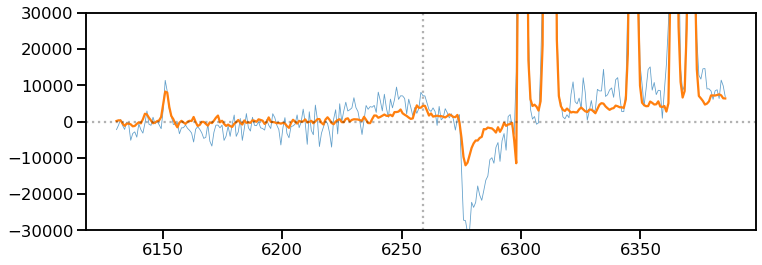

In [92]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(window_wavs, window_median)
ax.axvline(wav0_6259.value, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.set(
    ylim=[-30000, 30000],
);

So we still have a bit of Raman wing here. And there is some terrestrial absorption redward of 6270.  There looks like a chance of getting a reasonable continuum though.

Now take a smaller window:

In [93]:
NWIN = 100
window_slice = slice(k0_6259 - (NWIN//2), k0_6259 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
kwavs = kfull[window_slice]
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

[(-3000.0, 8000.0)]

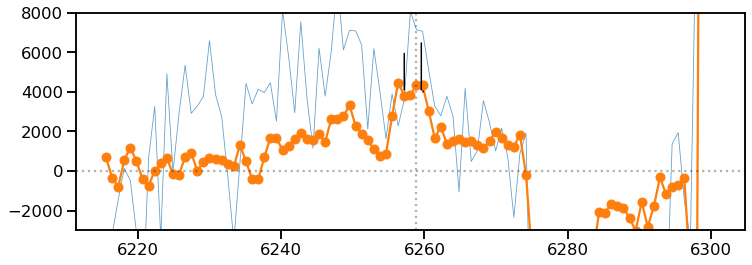

In [94]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(window_wavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(window_wavs, window_median, marker="o")
for wav, strength in line_strengths_6259.items():
    ax.annotate(
        " ", 
        (wav, 4000), 
        xytext=(0, 15 * strength), 
        textcoords="offset points",
        ha="center",
        arrowprops=dict(arrowstyle="-"),
    )

ax.axvline(wav0_6259.value, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.set(
    ylim=[-3000, 8000],
)

So there is not much point in separating the components. We should just add up the entire multiplet.

As a first try, I am tempted to not even subtract any continuum.  It may be that it is all just a bunch of blended lines. 

In [95]:
NWIN = 50
window_slice = slice(k0_6259 - (NWIN//2), k0_6259 + (NWIN//2) + 1)
window_cube = fullcube_nosky[window_slice, ...]
window_wavs = wavs[window_slice]
kwavs = kfull[window_slice]
window_median = np.median(window_cube, axis=(1, 2))
window_mean = np.mean(window_cube, axis=(1, 2))

[(-3000.0, 8000.0)]

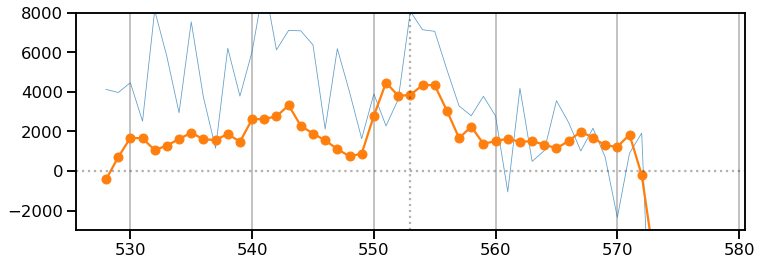

In [96]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kwavs, window_mean, alpha=0.7, linewidth=0.8)
ax.plot(kwavs, window_median, marker="o")
ax.axvline(k0_6259, color="k", linestyle="dotted", alpha=0.3)
ax.axhline(0.0, color="k", linestyle="dotted", alpha=0.3)
ax.grid(axis="x")
ax.set(
    ylim=[-3000, 8000],
)

Looks like 550 - 556 will get most of it.

In [97]:
cii6259_xmap = (fullcube_nosky[550:557, ...]).sum(axis=0)

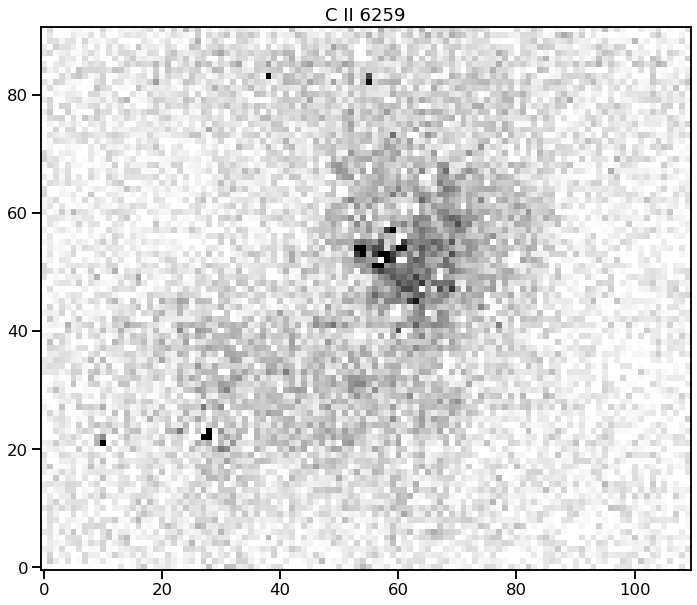

In [98]:
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cii6259_xmap, vmin=-3e4, vmax=5e5, origin="lower", cmap="gray_r")
ax.set_title("C II 6259");

# Ratios of various lines with respect to Ha

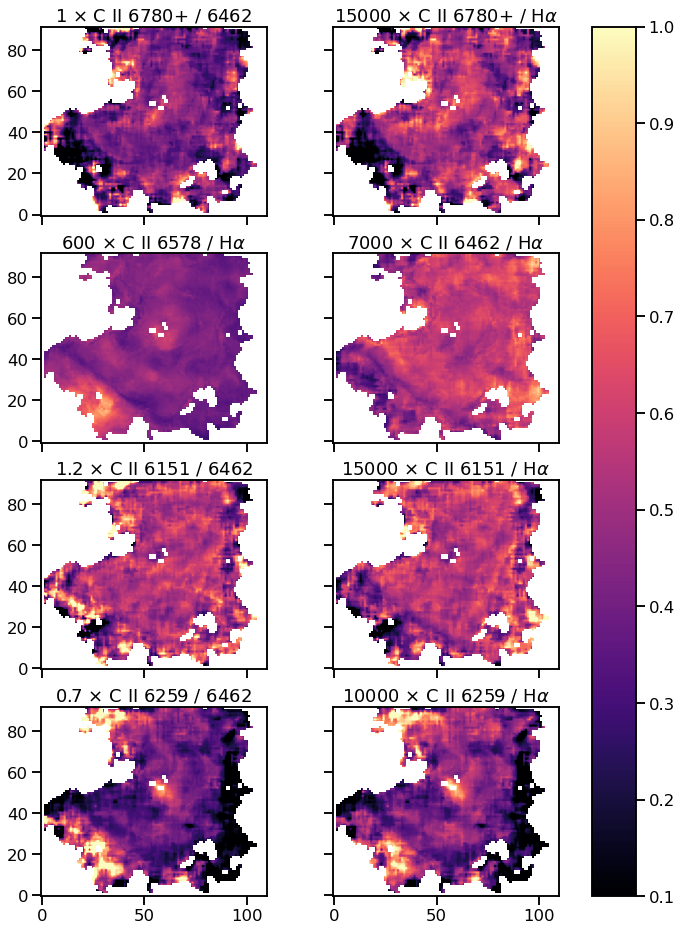

In [99]:
fig, axes = plt.subplots(
    4, 2, 
    figsize=(12, 16),
    sharex=True,
    sharey=True,
)
mask = ha_map < 0.7 * np.median(ha_map)
mask = mask | starmask
smooth = 6
for ax, _mapA, _mapB, labelA, labelB, FACTOR in zip(
    axes.flat,
    [
        (
            cii6780_xmap +
            cii6787_xmap
        ), 
        (
            cii6780_xmap +
            cii6787_xmap
        ), 
        cii6578_xmap,
        cii_xmap,
        cii6151_xmap,
        cii6151_xmap,
        cii6259_xmap,
        cii6259_xmap,
    ],
    [cii_xmap, ha_xmap, ha_map, ha_xmap, cii_xmap, ha_xmap, cii_xmap, ha_xmap, ],
    ["6780+", "6780+", "6578", "6462", "6151", "6151", "6259", "6259"],
    ["6462"] + [r"H$\alpha$"] * 3 + ["6462", r"H$\alpha$"] * 2,
    [1, 15_000, 600, 7_000, 1.2, 15_000, 0.7, 10_000],
):
    ratio = median_filter(_mapA, smooth) / median_filter(_mapB, smooth)
    ratio[mask] = np.nan
    im = ax.imshow(
        FACTOR * ratio, 
        vmin=0.1, vmax=1.0, 
        origin="lower", cmap="magma",
    )
    ax.set_title(fr"{FACTOR} $\times$ C II {labelA} / {labelB}");
fig.colorbar(im, ax=axes);

These look a lot more convincing now that I am using the narrow window.  
The first row shows sum of (6780 + 6787) over 6462 (left) or over Ha (right).  Similar features can be seen in both, which I suspect might be due to contamination by a blend with some low-ionization line. Possibly [Fe II]. 

The second row shows the fluorescent line 6578 (left) and the recombination line 6462 (right).  The 6780+ lines do not resemble 6578 at all. They show no signs of any of the 3 fluorescent peaks (Trapezium, Big Arc, and th2A). 

There is a slight resemblance between 6780+/Ha and 6462/Ha, especially at the Bright Bar.  But in many other respects it is different. There is a ridge of high 6790+/Ha that runs SE from near the Trapezium. 

If we ignore all that and just look at the values in the recombination emission near the bright bar, then we find 6780+/6462 is about 

In [100]:
select_mask = ~mask & (7000 * cii_xmap > 0.5 * ha_map)
ratio = (cii6780_xmap + cii6787_xmap)[select_mask].sum()
ratio /= cii_xmap[select_mask].sum()
ratio

0.309386974406389

So about 0.3

# Compare with the redder lines: 3d-3p $\lambda\lambda$7231, 7236

Note that the N III 4634, 4641, 4642 lines are the exact equivalent of these.  So they are probably also fluorescently excited. The equivalent of 6578 is 4097, 4103. There is also a pure recomb (presumably) line at 4379 (4f – 5g) and 3999, 4004 (4d – 5f).  

In [140]:
DATA_PATH = Path.cwd().parent / "data" 
cii7236_hdu = fits.open(
    DATA_PATH / "orig-muse" / "linesum-C_II-7236-bin002.fits"
)["SCALED"]

In [141]:
WCS(cii7236_hdu.header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.780566  -5.396172  
CRPIX : 1606.5  724.5  
PC1_1 PC1_2  : -5.55555555556e-05  0.0  
PC2_1 PC2_2  : 0.0  5.55555555556e-05  
CDELT : 1.0  1.0  
NAXIS : 1792  1536

In [142]:
cii7236_map = cii7236_hdu.data

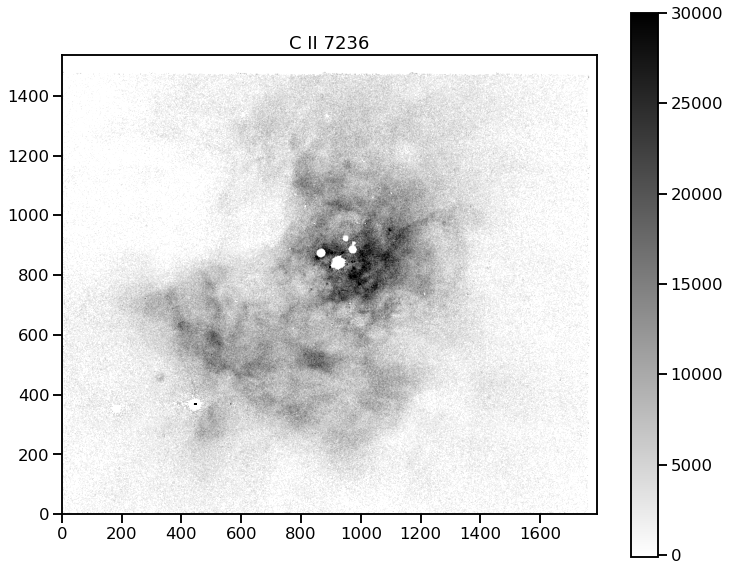

In [143]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(cii7236_map, vmin=-1e2, vmax=3e4, origin="lower", cmap="gray_r")
fig.colorbar(im, ax=ax)
ax.set_title("C II 7236");

In [144]:
ha_map2 = fits.open(
    DATA_PATH / "orig-muse" / "linesum-H_I-6563-bin002.fits"
)["SCALED"].data

In [145]:
cii7231_map = fits.open(
    DATA_PATH / "orig-muse" / "linesum-C_II-7231-bin002.fits"
)["SCALED"].data

In [146]:
xslice, yslice = slice(0, 400), slice(900, 1200)
sky7236 = np.median(cii7236_map[yslice, xslice])
sky7231 = np.median(cii7231_map[yslice, xslice])

<ipython-input-147-a797bad09fc9>:3: RuntimeWarning: divide by zero encountered in true_divide
  (cii7236_map - sky7236)/ ha_map2,


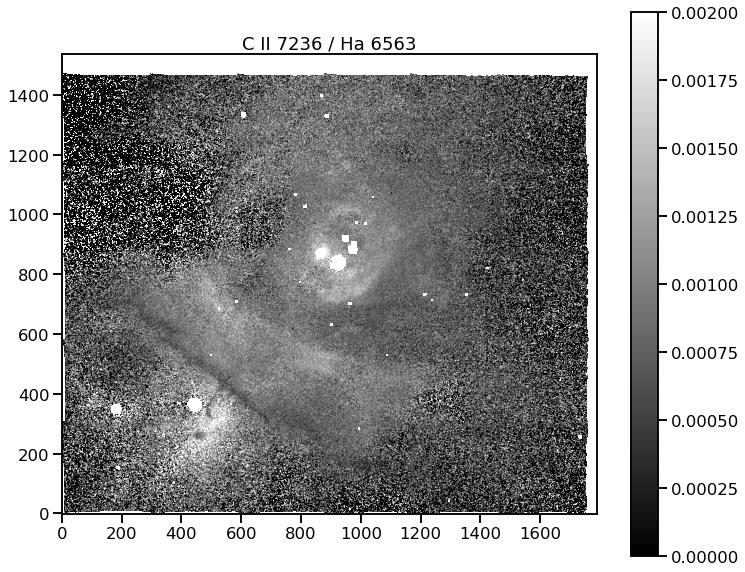

In [147]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(
    (cii7236_map - sky7236)/ ha_map2, 
    vmin=0.0, vmax=0.002, 
    origin="lower", 
    cmap="gray"
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 7236 / Ha 6563");

<ipython-input-148-e1a14273a401>:3: RuntimeWarning: divide by zero encountered in true_divide
  (cii7231_map - sky7231) / ha_map2,


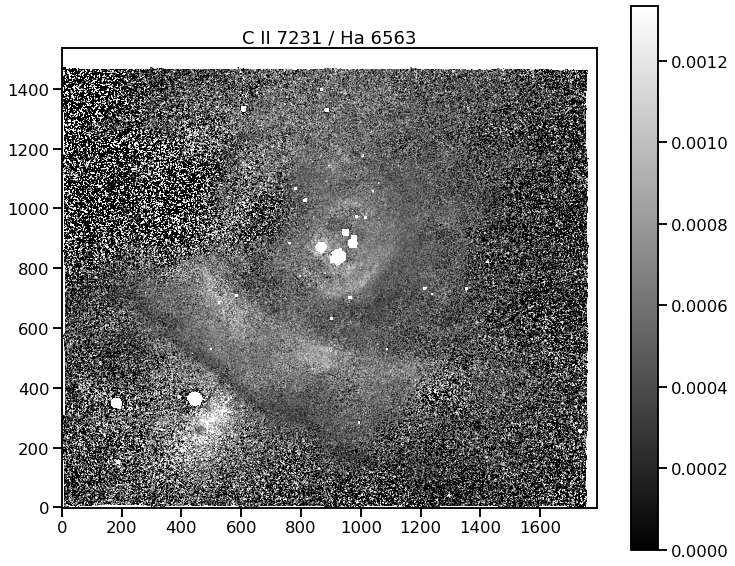

In [148]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(
    (cii7231_map - sky7231) / ha_map2, 
    vmin=0.0, vmax=0.002 * 2/3, 
    origin="lower", 
    cmap="gray"
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 7231 / Ha 6563");

<ipython-input-260-efa03f031c0e>:10: RuntimeWarning: divide by zero encountered in true_divide
  ratio = top / bot
<ipython-input-260-efa03f031c0e>:10: RuntimeWarning: invalid value encountered in true_divide
  ratio = top / bot


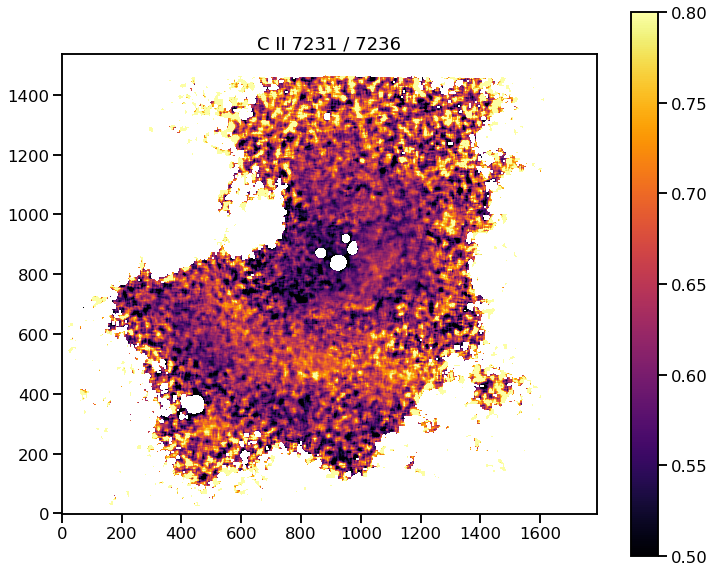

In [260]:
from scipy.signal import medfilt2d

fig, ax = plt.subplots(figsize=(12,10))

smooth = 1
top = medfilt2d(cii7231_map - sky7231, int(16 * smooth + 1)) 
bot = medfilt2d(cii7236_map - sky7236, int(16 * smooth + 1))
mask = top < 1.0 * np.nanmedian(top)

ratio = top / bot
ratio[mask] = np.nan
im = ax.imshow(
    ratio, 
    vmin=0.5, vmax=0.8, 
    origin="lower", 
    cmap="inferno"
)
fig.colorbar(im, ax=ax)
ax.set_title("C II 7231 / 7236");

So this is very interesting. The doublet ratio 7231/7236 is not constant. It is roughly 0.5 in the recombination-dominated regions, but is higher than that in some of the fluorescent regions, reaching values > 0.7 in the Big Arc, in the th2A region, and in HH 202. 

This might be related to density or it might be due to the excitation mechanism.  For recombination, there is a critical density above which the multiplet ratios take the LTE values (proportional to statistical weights). 

In [150]:
xslice, yslice = slice(0, 200), slice(900, 1200)
_bins = "016", "008", "004", "002", "001"
cii723X_multimap = np.zeros_like(cii7231_map)
ha_multimap = np.zeros_like(cii7231_map)
umbrales = 0.7, 1.5, 3.0, 9.0, 12.0
for _bin, umbral in zip(_bins, umbrales):
    ha_map2 = fits.open(
        DATA_PATH / "orig-muse" / f"linesum-H_I-6563-bin{_bin}.fits"
    )["SCALED"].data
    cii7236_map = fits.open(
        DATA_PATH / "orig-muse" / f"linesum-C_II-7236-bin{_bin}.fits"
    )["SCALED"].data
    cii7231_map = fits.open(
        DATA_PATH / "orig-muse" / f"linesum-C_II-7231-bin{_bin}.fits"
    )["SCALED"].data
    sky7236 = np.median(cii7236_map[yslice, xslice])
    sky7231 = np.median(cii7231_map[yslice, xslice])
    skyha = np.median(ha_map2[yslice, xslice])
    cii723X_map = (cii7236_map - sky7236) + (cii7231_map - sky7231)
    if _bin == "016":
        ha_map2_base = ha_map2
        cii723X_map_base = cii723X_map
        cii723X_multimap[...] = np.median(cii723X_map_base)
        ha_multimap[...] = np.median(ha_map2_base)
    mask = cii723X_map_base >= umbral * np.median(cii723X_map_base)
    print(_bin, mask.sum())
    #mask = mask & (ha_map2_base >= umbral * np.median(ha_map2_base))
    cii723X_multimap[mask] = cii723X_map[mask]
    ha_multimap[mask] = ha_map2[mask] - skyha

    


016 1753600
008 1056768
004 584448
002 29696
001 3328


In [151]:
ratio = cii723X_multimap / ha_multimap
fits.PrimaryHDU(
    header=cii7236_hdu.header,
    data=ratio,
).writeto(
    DATA_PATH / "orig-muse" / "ratio-723X-6563-multibin.fits",
    overwrite=True,
)

Make a version for the paper. But the true version is made in the Org file now.

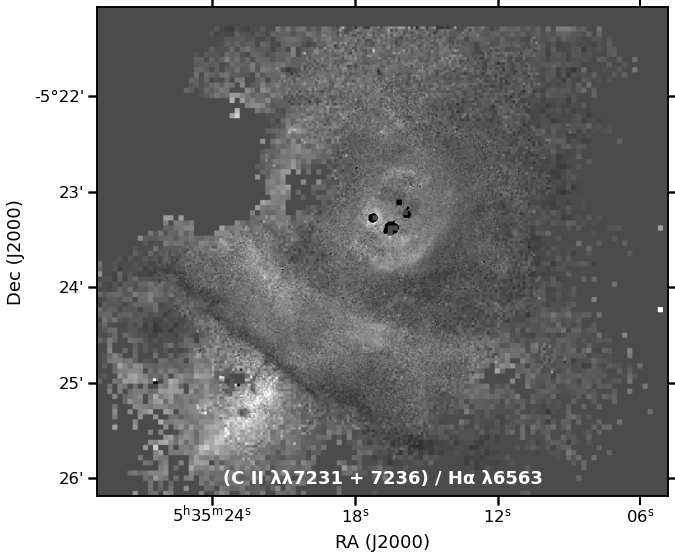

In [152]:
fig, ax = plt.subplots(
    figsize=(12,9),
    subplot_kw=dict(projection=WCS(cii7236_hdu.header)),
)
im = ax.imshow(
    ratio, 
    vmin=0.0, vmax=0.004,
    origin="lower", 
    cmap="gray"
)
#fig.colorbar(im, ax=ax)
ax.set(xlabel="RA (J2000)", ylabel="Dec (J2000)")
ax.set_title(
    "(C II λλ7231 + 7236) / Hα λ6563", 
    pad=12,
    y=0.0,
    fontweight="bold",
    color="w",
)
...;

In [153]:
xslice, yslice = slice(0, 200), slice(900, 1200)
_bins = "256", "128", "064", "032", "016", "008", "004", "002", "001"
cii7231_multimap = np.zeros_like(cii7231_map)
cii7236_multimap = np.zeros_like(cii7231_map)
umbrales = 0.5, 0.75, 1.0, 2.0, 3.0, 6.0, 12.0, 200.0, 500.0
for _bin, umbral in zip(_bins, umbrales):
    cii7236_map = fits.open(
        DATA_PATH / "orig-muse" / f"linesum-C_II-7236-bin{_bin}.fits"
    )["SCALED"].data
    cii7231_map = fits.open(
        DATA_PATH / "orig-muse" / f"linesum-C_II-7231-bin{_bin}.fits"
    )["SCALED"].data
    sky7236 = np.median(cii7236_map[yslice, xslice])
    sky7231 = np.median(cii7231_map[yslice, xslice])
    if _bin == _bins[0]:
        cii7231_map_base = cii7231_map
        cii7236_map_base = cii7236_map
        cii7231_multimap[...] = np.nanmedian(cii7231_map_base) - sky7231
        cii7236_multimap[...] = np.nanmedian(cii7236_map_base) - sky7236
    mask = cii7236_map >= umbral * np.median(cii7236_map)
    print(_bin, mask.sum())
    #mask = mask & (ha_map2_base >= umbral * np.median(ha_map2_base))
    cii7231_multimap[mask] = cii7231_map[mask] - sky7231
    cii7236_multimap[mask] = cii7236_map[mask] - sky7236

    


256 1900544
128 1687552
064 1376256
032 955392
016 675584
008 185088
004 8496
002 8
001 3


In [154]:
ratio_multiplet = cii7231_multimap / cii7236_multimap
fits.PrimaryHDU(
    header=cii7236_hdu.header,
    data=ratio,
).writeto(
    DATA_PATH / "orig-muse" / "ratio-7231-7236-multibin.fits",
    overwrite=True,
)

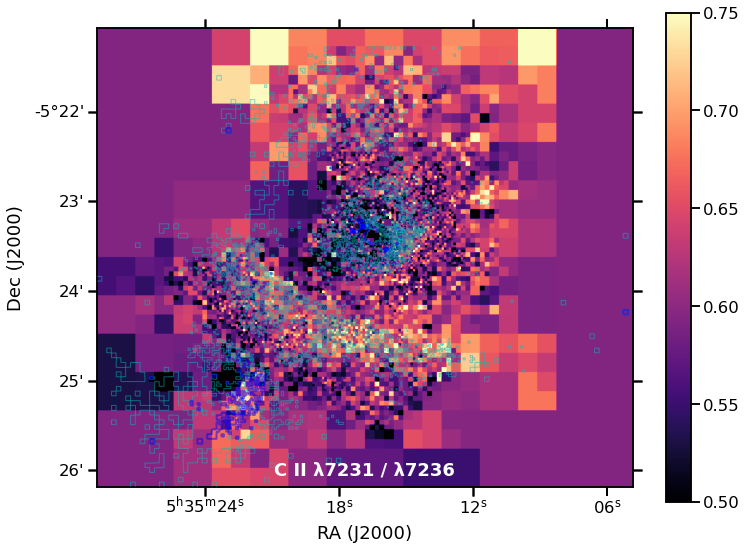

In [155]:
fig, ax = plt.subplots(
    figsize=(12,9),
    subplot_kw=dict(projection=WCS(cii7236_hdu.header)),
)
im = ax.imshow(
    ratio_multiplet, 
    vmin=0.5, vmax=0.75,
    origin="lower", 
    cmap="magma"
)
fig.colorbar(im, ax=ax)
ax.contour(
    ratio, 
    levels=[0.002, 0.003], 
    colors=["c", "b"], alpha=0.5, linewidths=[1., 2.])
ax.set(xlabel="RA (J2000)", ylabel="Dec (J2000)")
ax.set_title(
    "C II λ7231 / λ7236", 
    pad=12,
    y=0.0,
    fontweight="bold",
    color="w",
)
...;

To make further progress, I need to get everything on the same grid.  

For instance, I can repeat the above steps for the full-resolution cube. 

*Update: 2022-04-04*   What if we subtracted off 0.5 x 7231 instead 
of taking the ratio. That might be less noisy

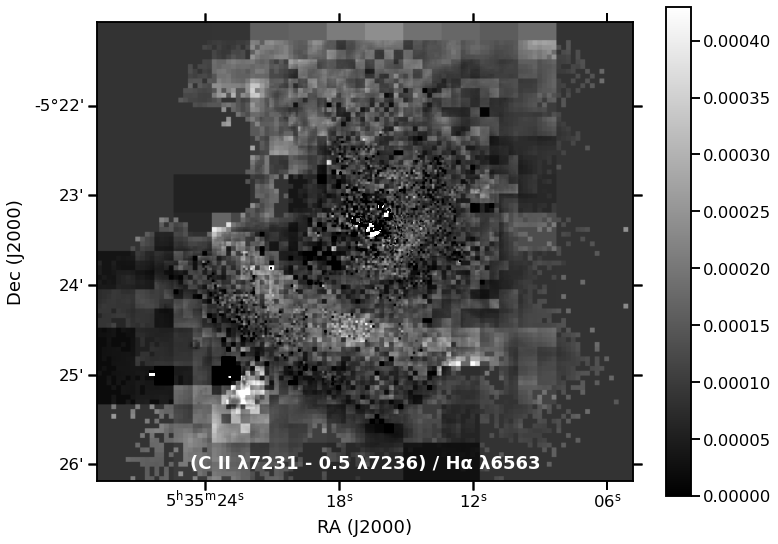

In [156]:
fig, ax = plt.subplots(
    figsize=(12,9),
    subplot_kw=dict(projection=WCS(cii7236_hdu.header)),
)
sub_map = (cii7231_multimap - 0.5 * cii7236_multimap) / ha_multimap
im = ax.imshow(
    sub_map, 
    vmin=0.0, vmax=5 * np.median(sub_map),
    origin="lower", 
    cmap="gray"
)
fig.colorbar(im, ax=ax)
ax.set(xlabel="RA (J2000)", ylabel="Dec (J2000)")
ax.set_title(
    "(C II λ7231 - 0.5 λ7236) / Hα λ6563", 
    pad=12,
    y=0.0,
    fontweight="bold",
    color="w",
)
...;

OK, this ix very noisy and does not look significantly better than  what we had before by summing the lines. 

## 3-color image of C II and Ha

In [196]:
from astropy.visualization import simple_norm

<ipython-input-243-314485461ea6>:5: RuntimeWarning: invalid value encountered in power
  (ha_multimap  / 45_000_000) ** (1.0 / gamma_r),
<ipython-input-243-314485461ea6>:7: RuntimeWarning: invalid value encountered in power
  (cii7231_multimap / 17_000) ** (1.0 / gamma),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


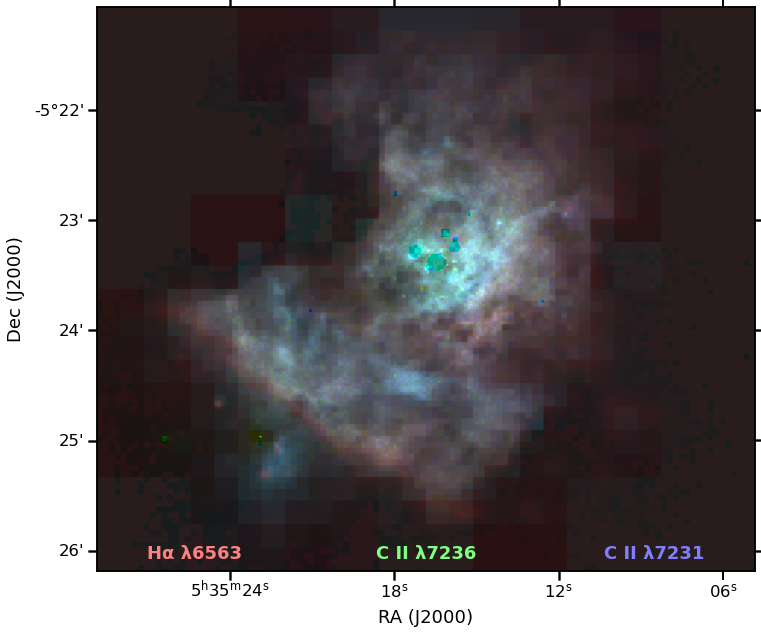

In [243]:
gamma = 1.1
gamma_r = 1.5
imstack = np.stack(
    [
        (ha_multimap  / 45_000_000) ** (1.0 / gamma_r),
        (cii7236_multimap / 30_000) ** (1.0 / gamma),
        (cii7231_multimap / 17_000) ** (1.0 / gamma),
    ],
    axis=-1,
)
fig, ax = plt.subplots(
    figsize=(11,9),
    subplot_kw=dict(projection=WCS(cii7236_hdu.header)),
)
im = ax.imshow(
    imstack, 
    origin="lower", 
)
ax.set(xlabel="RA (J2000)", ylabel="Dec (J2000)")
ax.set_title(
    "        Hα λ6563", 
    loc="left",
    pad=12,
    y=0.0,
    fontweight="bold",
    color=(1.0, 0.5, 0.5),
)
ax.set_title(
    "C II λ7236", 
    loc="center",
    pad=12,
    y=0.0,
    fontweight="bold",
    color=(0.5, 1.0, 0.5),
)
ax.set_title(
    "C II λ7231        ", 
    loc="right",
    pad=12,
    y=0.0,
    fontweight="bold",
    color=(0.5, 0.5, 1.0),
)
fig.tight_layout(rect=[0.08, 0.07, 1.0, 1.0])
fig.savefig("../figs/rgb-ha-cii-7236-7231.pdf")
...;
from astropy.visualization import make_lupton_rgb

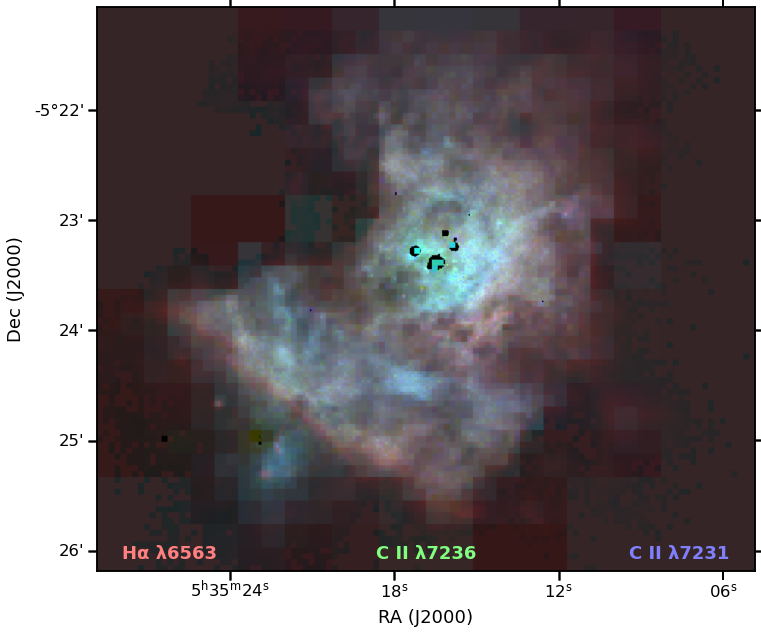

In [242]:
fig, ax = plt.subplots(
    figsize=(11,9),
    subplot_kw=dict(projection=WCS(cii7236_hdu.header)),
)
im = ax.imshow(
    make_lupton_rgb(
        imstack[..., 0],
        imstack[..., 1],
        imstack[..., 2],
        Q=1.5,
        stretch=0.75,
    ),
    origin="lower", 
)
ax.set(xlabel="RA (J2000)", ylabel="Dec (J2000)")
ax.set_title(
    "    Hα λ6563", 
    loc="left",
    pad=12,
    y=0.0,
    fontweight="bold",
    color=(1.0, 0.5, 0.5),
)
ax.set_title(
    "C II λ7236", 
    loc="center",
    pad=12,
    y=0.0,
    fontweight="bold",
    color=(0.5, 1.0, 0.5),
)
ax.set_title(
    "C II λ7231    ", 
    loc="right",
    pad=12,
    y=0.0,
    fontweight="bold",
    color=(0.5, 0.5, 1.0),
)
fig.tight_layout(rect=[0.08, 0.07, 1.0, 1.0])
fig.savefig("../figs/rgb-lupton-ha-cii-7236-7231.pdf")
...;